In [218]:
import collections
from datetime import datetime as dt
from datetime import timedelta
from edgar import Company
import graphviz
import json
import lxml.html as lh
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import pandas_datareader as pdr
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import re
import requests
import sec_scraper
import statsmodels.api as sm
from sklearn import metrics, preprocessing
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import ElasticNet, LinearRegression, LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.svm import SVC
import time
import warnings
from yellowbrick.regressor import ResidualsPlot
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 100
plotly.offline.init_notebook_mode()
warnings.filterwarnings('ignore')

In [227]:
# Functions for getting the CIK and Company Name from a SPAC ticker

def get_ticker_to_cik(write=False):
    # local copy: data/ticker_to_cik.txt
    ticker_to_cik = pd.read_csv('https://www.sec.gov/include/ticker.txt',
                                sep='\t', header=None, names=['ticker','cik'])
    if write:
        ticker_to_cik.to_csv('data/ticker_to_cik.csv', index=False)
    ticker_to_cik['ticker'] = ticker_to_cik.ticker.str.upper()
    ticker_to_cik['cik'] = ticker_to_cik.cik.astype(str)
    return ticker_to_cik

def get_cik_to_name(write=False):
    # local copy: data/cik_to_name.json
    cik_to_name = pd.read_json('https://www.sec.gov/files/company_tickers.json').transpose()
    if write:
        cik_to_name.to_csv('data/cik_to_name.csv', index=False)
    cik_to_name['ticker'] = cik_to_name.ticker.str.upper()
    cik_to_name['cik'] = cik_to_name.cik_str.astype(str)
    return cik_to_name

def update_current_spacs(file_path_current, write=False):
    df_traq = pd.read_csv('https://docs.google.com/spreadsheets/d/14BY8snyHMbUReQVRgZxv4U4l1ak79dWFIymhrLbQpSo/'
                             'export?gid=0&format=csv', header=2)
    df_traq.columns = [x.replace('\n','') for x in df_traq.columns]
    df_spacs_existing = pd.read_csv(file_path_current)
    df_spacs_existing.drop_duplicates(inplace=True)
    combined_spacs = df_spacs_existing['Ticker'].append(df_traq['Issuer Symbol'])
    df_spacs_new = pd.DataFrame(combined_spacs, columns=['Ticker'])
    df_spacs_new.drop_duplicates(inplace=True)
    df_spacs_new.reset_index(inplace=True, drop=True)
    new_added_tickers = [x for x in df_spacs_new['Ticker'].tolist()
                         if x not in df_spacs_existing['Ticker'].tolist()]
    if len(new_added_tickers) > 0:
        print('newly added tickers:', new_added_tickers)
    if write:
        df_spacs_new.to_csv(file_path_current, index=False)
    return

def process_current_spacs(file_path_current, write=False):
    # current spac list
    spac_list_current = pd.read_csv(file_path_current)
    spac_list_current = spac_list_current.Ticker.unique()
    spac_list_current = pd.DataFrame(spac_list_current, columns=['Ticker'])
    
    # write to file
    if write==True:
        spac_list_current.to_csv('spac_list_current.csv', index=False)
        
    # get ticker to cik and cik to company name file, then merge
    ticker_to_cik = get_ticker_to_cik(write=write)
    cik_to_name = get_cik_to_name(write=write)
    spac_list_current = spac_list_current.merge(ticker_to_cik, how='left', left_on='Ticker', right_on='ticker')
    spac_list_current = spac_list_current.merge(cik_to_name[['cik','ticker','title']], how='left', on=['cik','ticker'])
    
    # some current spacs have not split from units to stock + warrants so ticker in sec different
    ticker_unit = pd.DataFrame(spac_list_current[spac_list_current.ticker.isna()]['Ticker'])
    ticker_unit['Ticker'] = ticker_unit.Ticker + 'U'
    ticker_unit = ticker_unit.merge(ticker_to_cik, how='left', left_on='Ticker', right_on='ticker')
    ticker_unit = ticker_unit.merge(cik_to_name[['cik','ticker','title']], how='left', on=['cik','ticker'])
    ticker_unit['Ticker'] = ticker_unit.Ticker.apply(lambda x: x[:-1] if not pd.isnull(x) else x)
    ticker_unit['ticker'] = ticker_unit.ticker.apply(lambda x: x[:-1] if not pd.isnull(x) else x)
    ticker_unit_other = pd.DataFrame(ticker_unit[ticker_unit.ticker.isna()]['Ticker'])
    ticker_unit_other['Ticker'] = ticker_unit_other.Ticker.apply(lambda x: x+'-UN')
    ticker_unit_other = ticker_unit_other.merge(ticker_to_cik, how='left', left_on='Ticker', right_on='ticker')
    ticker_unit_other = ticker_unit_other.merge(cik_to_name[['cik','ticker','title']], how='left', on=['cik','ticker'])
    ticker_unit_other['Ticker'] = ticker_unit_other.Ticker.apply(lambda x: x[:-3] if not pd.isnull(x) else x)
    ticker_unit_other['ticker'] = ticker_unit_other.ticker.apply(lambda x: x[:-3] if not pd.isnull(x) else x)
    ticker_unit = ticker_unit.append(ticker_unit_other)
    ticker_unit.dropna(inplace=True)
    
    # append tickers found using 'U' and '-UN'
    spac_list_current = spac_list_current[~spac_list_current.Ticker.isin(ticker_unit.Ticker)]
    spac_list_current = spac_list_current.append(ticker_unit)
    
    print('count current spacs:', len(spac_list_current))
    print('count nan in current spacs:', len(spac_list_current[spac_list_current.ticker.isna()]))
    
    return spac_list_current
    
def process_past_spacs(file_path_past, write=False):
    # past spac list (completed business combination)
    spac_list_past = pd.read_csv(file_path_past)
    spac_list_past.fillna('missing', inplace=True)
    spac_list_past['dupe_filter'] = spac_list_past['Old Ticker'] + spac_list_past['New Ticker']
    spac_list_past = spac_list_past[spac_list_past.dupe_filter.isin(spac_list_past.dupe_filter.unique())]
    spac_list_past.drop(columns=['dupe_filter'], inplace=True)
    
    # write to file
    if write==True:
        spac_list_past.to_csv('spac_list_past.csv', index=False)
        
    # get ticker to cik and cik to company name file, then merge
    ticker_to_cik = get_ticker_to_cik(write=write)
    cik_to_name = get_cik_to_name(write=write)
    spac_list_past = spac_list_past.merge(ticker_to_cik, how='left', left_on='New Ticker', right_on='ticker')
    spac_list_past = spac_list_past.merge(ticker_to_cik, how='left', left_on='Old Ticker', right_on='ticker')
    spac_list_past.rename(columns={'ticker_x':'ticker','cik_x':'cik','cik_y':'cik_old'}, inplace=True)
    spac_list_past.drop(columns='ticker_y', inplace=True)
    spac_list_past = spac_list_past.merge(cik_to_name[['cik','ticker','title']], how='left', on=['cik','ticker'])

    print('count past spacs:', len(spac_list_past))
    print('count nan in past spacs:', len(spac_list_past[spac_list_past.ticker.isna()]))
    
    return spac_list_past

In [220]:
# Functions for pulling 8-K html, converting to text, grabbing date, and simple text match classifier

def basic_text_cleaning(text):
    text = text.replace('\n',' ').replace('\xa0',' ') # replace some unicode characters
    text = re.sub(' +', ' ', text) # remove extra spaces
    text = text.lower()
    return text

def get_forms_text(company_name, cik_id, form_type):
    c = sec_scraper.Company(company_name, cik_id, timeout=20)
    filings = c.get_all_filings(filing_type=form_type, no_of_documents=100)
    dates = [f.accepted_date.strftime('%Y-%m-%d %H:%M:%S') for f in filings]
    documents = [basic_text_cleaning(f.documents[0]) for f in filings]
    urls = [f.url for f in filings]
    print(company_name, cik_id)
    df = pd.DataFrame(list(zip(dates, documents, urls)), columns=['date','text','url'])
    df['form'] = '8-K'
    df['accepted_time'] = df.date
    df['date'] = df.date.apply(lambda x: x[0:10])
    df['url'] = df.url
    return df

def basic_text_match(df_form, substring):
    df_form[substring.replace(' ','_')+'_found'] = df_form.text.apply(lambda x: 1 if substring in x else 0)
    return df_form

In [221]:
# Functions for grabbing and saving price data

def bulk_save_prices_to_csv(symbols, start_date, end_date, price_source, is_warrant=False):
    for ind, symbol in enumerate(symbols):
        print(symbol)
        df_prices = get_historical_prices(symbol=symbol,
                                          start_date=start_date,
                                          end_date=end_date,
                                          price_source=price_source,
                                          is_warrant=is_warrant)
        if df_prices is not None:
            df_prices = process_historical_prices(df_prices)
            df_prices.to_csv('data/prices_'+price_source+'/'+symbol+'_prices.csv', index=False)
        # TD and alphavantage limits query rate
        if ind%10==0 and ind!=0:
            time.sleep(30)
        
def run_bulk_save_prices(spac_list_current, spac_list_past, price_source, is_warrant=False):
    # spacs missing price data entirely
    missing_past_spacs = ['missing', 'LCAH', 'FMCI1', 'CFCO']
    missing_current_spacs = ['ACNDU', 'ARYB', 'BRLI', 'DFHT', 'DMYD', 'FUSE', 'GOAC', 'IWAC', 'LCAH', 'LGVW',
                             'MCAC', 'MLAC', 'PANA', 'PSAC', 'PSTH', 'SSMC', 'TREB']
    
    symbols_past_new_ticker = [x for x in spac_list_past.ticker.unique().tolist() if str(x)!='nan']
    symbols_past_old_ticker = spac_list_past['Old Ticker'].unique().tolist()
    symbols_past_old_ticker = [x for x in symbols_past_old_ticker if x not in missing_past_spacs]
    symbols_current = [x for x in spac_list_current['Ticker'] if x not in missing_current_spacs]
    if is_warrant:
        symbols_past_new_ticker = [x + 'W' for x in symbols_past_new_ticker]
        symbols_past_old_ticker = [x + 'W' for x in symbols_past_old_ticker]
        symbols_current = [x + 'W' for x in symbols_current]
    bulk_save_prices_to_csv(symbols=symbols_past_new_ticker, start_date='2018-01-01',
                            end_date=dt.today().strftime('%Y-%m-%d'), price_source=price_source, is_warrant=is_warrant)
    bulk_save_prices_to_csv(symbols=symbols_past_old_ticker, start_date='2018-01-01',
                            end_date=dt.today().strftime('%Y-%m-%d'), price_source=price_source, is_warrant=is_warrant)
    bulk_save_prices_to_csv(symbols=symbols_current, start_date='2018-01-01',
                            end_date=dt.today().strftime('%Y-%m-%d'), price_source=price_source, is_warrant=is_warrant)

def get_td_key_locally():
    f = open("data/td_consumer_key.txt", "r")
    return f.read()

def millis_since_epoch_to_dt(x):
    return dt.fromtimestamp(float(x)/1000).strftime('%Y-%m-%d %H:%M:%S.%f')

def dt_to_millis_since_epoch(x):
    epoch = dt.utcfromtimestamp(0)
    return str(int((x-epoch).total_seconds()*1000))

def get_prices_td(symbol, start_date, end_date, minute_freq=False):
    TD_CONSUMER_KEY = get_td_key_locally()
    start_date_epoch = dt_to_millis_since_epoch(dt.strptime(start_date, '%Y-%m-%d'))
    end_date_epoch = dt_to_millis_since_epoch(dt.strptime(end_date, '%Y-%m-%d'))
    partial_url = 'https://api.tdameritrade.com/v1/marketdata/{symbol}/pricehistory?'
    # minute-to-minute prices (<2 months available)
    if minute_freq:
        endpoint = partial_url+'periodType=day&frequencyType=minute&startDate={start_date}&endDate={end_date}'
    # daily open-close prices
    else:
        endpoint = partial_url+'periodType=month&frequencyType=daily&startDate={start_date}&endDate={end_date}'
    full_url = endpoint.format(symbol=symbol,
                               start_date=start_date_epoch,
                               end_date=end_date_epoch)
    page = requests.get(url=full_url, params={'apikey' : TD_CONSUMER_KEY})
    content = json.loads(page.content)
    try:
        df_td_prices = pd.DataFrame.from_dict(content['candles'])
    except:
        return None
    if len(df_td_prices)==0:
        return None
    df_td_prices['datetime'] = df_td_prices.datetime.apply(lambda x: millis_since_epoch_to_dt(x))
    df_td_prices['date'] = df_td_prices.datetime.apply(lambda x: x[0:10])
    df_td_prices['ticker'] = symbol
    return df_td_prices

def get_historical_prices(symbol, start_date, end_date, price_source, is_warrant=False):
    print('getting prices from', start_date, 'to', end_date, 'for', symbol)
    if price_source=='td':
        df_prices = get_prices_td(symbol, start_date, end_date)
        if df_prices is None and is_warrant:
            df_prices = get_prices_td(symbol[:-1]+'.WS', start_date, end_date)
    else:
        start_split = start_date.split('-')
        end_split = end_date.split('-')
        start = dt(int(start_split[0]), int(start_split[1]), int(start_split[2]))
        end = dt(int(end_split[0]), int(end_split[1]), int(end_split[2]))
        try:
            # be careful with missing/limited data in yahoo data
            if price_source=='yahoo':
                df_prices = pdr.data.DataReader(name=symbol, data_source='yahoo', start=start, end=end)
            # alphavantage seems to be most reliable. 5 calls per minute and 500 calls per day
            if price_source=='alphavantage':
                df_prices = pdr.data.DataReader(name=symbol, data_source='av-daily', start=start, end=end,
                                                api_key='BDB9WJQRCZKINCLD')
            # iex has extremely limited api calls
            if price_source=='iex':
                df_prices = pdr.data.DataReader(name=symbol, data_source='iex', start=start, end=end,
                                                api_key='pk_970dfff359894b15a056cf677c02e11f')
            df_prices.reset_index(inplace=True)
            df_prices.rename(columns={'index':'date'}, inplace=True)
        except:
            return None
    return df_prices

def process_historical_prices(df_prices, conservative_est=False):
    df_prices.columns = df_prices.columns.str.lower()
    df_prices['date'] = df_prices.date.astype(str)
    # if using conservative estimate, mark return to open_t+1
    if conservative_est:
        df_prices['open_t+1'] = df_prices['open'].shift(-1)
        df_prices['close_t+1'] = df_prices['close'].shift(-1)
        df_prices['close_t+3'] = df_prices['close'].shift(-3)
        df_prices['close_t+5'] = df_prices['close'].shift(-5)
        df_prices['close_t+7'] = df_prices['close'].shift(-7)
        df_prices['open_close_t+1_%chg'] = (df_prices['close_t+1'] - df_prices['open_t+1']) / df_prices['open_t+1']
        df_prices['open_close_t+3_%chg'] = (df_prices['close_t+3'] - df_prices['open_t+1']) / df_prices['open_t+1']
        df_prices['open_close_t+5_%chg'] = (df_prices['close_t+5'] - df_prices['open_t+1']) / df_prices['open_t+1']
        df_prices['open_close_t+7_%chg'] = (df_prices['close_t+7'] - df_prices['open_t+1']) / df_prices['open_t+1']
    else:
        df_prices['close_t+1'] = df_prices['close'].shift(-1)
        df_prices['close_t+3'] = df_prices['close'].shift(-3)
        df_prices['close_t+5'] = df_prices['close'].shift(-5)
        df_prices['close_t+7'] = df_prices['close'].shift(-7)
        df_prices['open_close_t+1_%chg'] = (df_prices['close_t+1'] - df_prices['open']) / df_prices['open']
        df_prices['open_close_t+3_%chg'] = (df_prices['close_t+3'] - df_prices['open']) / df_prices['open']
        df_prices['open_close_t+5_%chg'] = (df_prices['close_t+5'] - df_prices['open']) / df_prices['open']
        df_prices['open_close_t+7_%chg'] = (df_prices['close_t+7'] - df_prices['open']) / df_prices['open']
    df_prices = df_prices.round(2)
    print('output min date:', df_prices.date.min())
    print('output max date:', df_prices.date.max())
    return df_prices

In [222]:
# Functions outputting dataframe of 8-Ks, classification, and 1,3,5,7 day returns

def agg_spac_returns(spac_list, price_source, is_warrant=False, write=False, conservative_est=False):
    df_returns_agg = pd.DataFrame()
    count_missing_8K = 0
    for ind in range(0, len(spac_list)):
        row = spac_list.iloc[ind]
        print('index:', ind)
        print(row.ticker)
        
        broken_current_spacs = ['GNRS','KBLM','LGC','LIVE','NOVS']
        if is_warrant:
            broken_current_spacs = [x + 'W' for x in broken_current_spacs]
        if row.ticker in broken_current_spacs:
            print('in broken spac list, skipping...')
            continue

        # get form 8Ks
        df_form_8K = get_forms_text(company_name=row.title, cik_id=row.cik, form_type='8-K')
        if df_form_8K is None or len(df_form_8K)==0:
            print('no 8Ks found, trying cik_old...')
            if 'cik_old' in row.index:
                df_form_8K = get_forms_text(company_name=row.title, cik_id=row.cik_old, form_type='8-K')
        if df_form_8K is None or len(df_form_8K)==0:
            print('no 8Ks found, skipping...\n')
            count_missing_8K = count_missing_8K + 1
            continue
        else:
            if write:
                df_form_8K.to_csv('data/sec_filings_df/'+row.ticker+'_sec_forms.csv', index=False)
            # simple classifier
            df_form_8K = basic_text_match(df_form_8K, 'letter of intent')
            df_form_8K = basic_text_match(df_form_8K, 'business combination agreement')

        # get stock or warrant prices
        try:
            # load saved data
            df_prices = pd.read_csv('data/prices_'+price_source+'/'+row.ticker+'_prices.csv') 
            print('price data min date:', df_prices.date.min())
            print('price data max date:', df_prices.date.max())
        except:
            df_prices = get_historical_prices(symbol=row.ticker,
                                              start_date='2018-01-01',
                                              end_date=dt.today().strftime('%Y-%m-%d'),
                                              price_source=price_source,
                                              is_warrant=is_warrant)
        if df_prices is None:
            print('prices for', row.ticker, 'not found. skipping...\n')
            continue
        df_prices = process_historical_prices(df_prices, conservative_est)

        # merge sec forms and price data on date
        df_returns = df_form_8K.merge(df_prices[['date','open_close_t+1_%chg','open_close_t+3_%chg',
                                                 'open_close_t+5_%chg','open_close_t+7_%chg']],
                                      how='left', on='date')
        display(df_returns)

        # append
        if len(df_returns)!=0:
            df_returns['symbol'] = row.ticker
        df_returns_agg = df_returns_agg.append(df_returns)
        
        # sec site sometimes will timeout
        if ind%10==0 and ind!=0:
            time.sleep(30) # set to at least 120 loading sec forms from scratch
        
    # drop duplicates on date + symbol
    # todo: if date has multipled 8-Ks, concatenate instead of dropping
    print('count sec forms before dropping duplicates:', len(df_returns_agg))
    df_returns_agg = df_returns_agg.drop_duplicates(subset=['date','symbol'])
    print('count sec forms after dropping duplicates:', len(df_returns_agg))
    
    print('\n##############\ncount symbols missing 8-Ks:', count_missing_8K, '\n##############\n')
    
    return df_returns_agg

def load_all_spacs(use_saved_df=True, write=False, warrants_only=False, conservative_est=False):
    if conservative_est:
        path_returns = 'data/returns/conservative/'
    else:
        path_returns = 'data/returns/'
    if use_saved_df:
        df_returns_past_warrants_newticker = pd.read_csv(path_returns+'df_returns_past_warrants_newticker.csv')
        df_returns_past_warrants_oldticker = pd.read_csv(path_returns+'df_returns_past_warrants_oldticker.csv')
        df_returns_current_warrants = pd.read_csv(path_returns+'df_returns_current_warrants.csv')
        if warrants_only:
            return df_returns_past_warrants_newticker, df_returns_past_warrants_oldticker, df_returns_current_warrants
        df_returns_past = pd.read_csv(path_returns+'df_returns_past.csv')
        df_returns_current = pd.read_csv(path_returns+'df_returns_current.csv')
        return df_returns_past, df_returns_current, df_returns_past_warrants_newticker, df_returns_past_warrants_oldticker, df_returns_current_warrants
    else:
        # get returns following 8-Ks for past spac warrants (new and old tickers)
        spac_list_past_warrants_newticker = spac_list_past.copy()
        spac_list_past_warrants_newticker['ticker'] = spac_list_past_warrants_newticker['New Ticker'] + 'W' # warrants
        df_returns_past_warrants_newticker = agg_spac_returns(spac_list_past_warrants_newticker,
                                                              price_source='td',
                                                              is_warrant=True,
                                                              write=write,
                                                              conservative_est=conservative_est)
        spac_list_past_warrants_oldticker = spac_list_past.copy()
        spac_list_past_warrants_oldticker['ticker'] = spac_list_past_warrants_oldticker['Old Ticker'] + 'W' # warrants
        df_returns_past_warrants_oldticker = agg_spac_returns(spac_list_past_warrants_oldticker,
                                                              price_source='td',
                                                              is_warrant=True,
                                                              write=write,
                                                              conservative_est=conservative_est)

        # get returns following 8-Ks for current spac warrants
        spac_list_current_warrants = spac_list_current.copy()
        spac_list_current_warrants['ticker'] = spac_list_current_warrants.Ticker + 'W' # warrants
        df_returns_current_warrants = agg_spac_returns(spac_list_current_warrants,
                                                       price_source='td',
                                                       is_warrant=True,
                                                       write=write,
                                                       conservative_est=conservative_est)
        if warrants_only:
            return df_returns_past_warrants_newticker, df_returns_past_warrants_oldticker, df_returns_current_warrants
        
        # get returns following 8-Ks for past spacs
        df_returns_past = agg_spac_returns(spac_list_past,
                                           price_source='td',
                                           is_warrant=False,
                                           write=write,
                                           conservative_est=conservative_est)

        # get returns following 8-Ks for current spacs
        df_returns_current = agg_spac_returns(spac_list_current,
                                              price_source='td',
                                              is_warrant=False,
                                              write=write,
                                              conservative_est=conservative_est)

        if write:
            df_returns_past.to_csv(path_returns+'df_returns_past.csv', index=False)
            df_returns_current.to_csv(path_returns+'df_returns_current.csv', index=False)
            df_returns_past_warrants_newticker.to_csv(path_returns+'df_returns_past_warrants_newticker.csv', index=False)
            df_returns_past_warrants_oldticker.to_csv(path_returns+'df_returns_past_warrants_oldticker.csv', index=False)
            df_returns_current_warrants.to_csv(path_returns+'df_returns_current_warrants.csv', index=False)
            
    return df_returns_past, df_returns_current, df_returns_past_warrants_newticker, df_returns_past_warrants_oldticker, df_returns_current_warrants

In [233]:
# update current spac list
update_current_spacs(file_path_current='data/spac_list_current.csv', write=True)

# load current and past spac lists
spac_list_current = process_current_spacs(file_path_current='data/spac_list_current.csv', write=False)
spac_list_past = process_past_spacs(file_path_past='data/spac_list_past.csv', write=False)

# bulk save price data for symbols in spac lists (due to API limits)...no need to run if already saved
# run_bulk_save_prices(spac_list_current, spac_list_past, price_source='td', is_warrant=False)
# run_bulk_save_prices(spac_list_current, spac_list_past, price_source='td', is_warrant=True)

count current spacs: 136
count nan in current spacs: 7
count past spacs: 52
count nan in past spacs: 5


In [235]:
# load returns for all spacs (stock and warrants) with returns calculated from open on form accepted date
# df_returns_past, df_returns_current, df_returns_past_warrants_newticker, df_returns_past_warrants_oldticker, df_returns_current_warrants = load_all_spacs(use_saved_df=True, write=False, warrants_only=False, conservative_est=False)

# load returns for all spacs (warrants only) with returns calculated from open on form accepted date
# df_returns_past_warrants_newticker, df_returns_past_warrants_oldticker, df_returns_current_warrants = load_all_spacs(use_saved_df=True, write=False, warrants_only=True, conservative_est=False)

# load returns for all spacs (stock and warrants) with returns calculated from open on form accepted date + 1 day (conservative)
df_returns_past, df_returns_current, df_returns_past_warrants_newticker, df_returns_past_warrants_oldticker, df_returns_current_warrants = load_all_spacs(use_saved_df=True, write=False, warrants_only=False, conservative_est=True)

# load returns for all spacs (warrants only) with returns calculated from open on form accepted date + 1 day (conservative)
# df_returns_past_warrants_newticker, df_returns_past_warrants_oldticker, df_returns_current_warrants = load_all_spacs(use_saved_df=True, write=False, warrants_only=True, conservative_est=True)


print('count current spacs with 8-Ks found:', len(df_returns_current.symbol.unique()))
print('count past spacs with 8-Ks found', len(df_returns_past.symbol.unique()))

count current spacs with 8-Ks found: 106
count past spacs with 8-Ks found 44


## Analysis

In [34]:
# Functions for backtest
# note .123 is 12.3% in output

def compute_mean_returns(df_returns, corrupt_symbols, includes_hourly=False):
    if len(corrupt_symbols)!=0:
        print('Symbols removed:', corrupt_symbols)
    if includes_hourly:
        agg_dict = {'accepted_time_t+1hr_%chg':'mean','accepted_time_t+3hr_%chg':'mean',
                    'accepted_time_t+5hr_%chg':'mean','accepted_time_t+7hr_%chg':'mean',
                    'open_close_t+1_%chg':'mean','open_close_t+3_%chg':'mean',
                    'open_close_t+5_%chg':'mean','open_close_t+7_%chg':'mean'}
    else:
        agg_dict = {'open_close_t+1_%chg':'mean','open_close_t+3_%chg':'mean',
                    'open_close_t+5_%chg':'mean','open_close_t+7_%chg':'mean'}
    df_mean_returns = df_returns[~df_returns.symbol.isin(corrupt_symbols)].groupby('symbol').agg(agg_dict)
    df_mean_returns.dropna(inplace=True)
    print('Count:', len(df_mean_returns))
    return np.round(df_mean_returns, 3)

def summary_statistics(df_returns, corrupt_symbols):
    if len(corrupt_symbols)!=0:
        print('Symbols removed:', corrupt_symbols)
    return np.round(df_returns[~df_returns.symbol.isin(corrupt_symbols)].dropna().describe(), 3)

def compute_mean_returns_LOI(df_returns, corrupt_symbols, includes_hourly=False):
    if len(corrupt_symbols)!=0:
        print('Symbols removed:', corrupt_symbols)
    if includes_hourly:
        agg_dict = {'accepted_time_t+1hr_%chg':'mean','accepted_time_t+3hr_%chg':'mean',
                    'accepted_time_t+5hr_%chg':'mean','accepted_time_t+7hr_%chg':'mean',
                    'open_close_t+1_%chg':'mean','open_close_t+3_%chg':'mean',
                    'open_close_t+5_%chg':'mean','open_close_t+7_%chg':'mean'}
    else:
        agg_dict = {'open_close_t+1_%chg':'mean','open_close_t+3_%chg':'mean',
                    'open_close_t+5_%chg':'mean','open_close_t+7_%chg':'mean'}
    return np.round(df_returns[(~df_returns.symbol.isin(corrupt_symbols)) &
                               (df_returns.letter_of_intent_found==1)].dropna().groupby('symbol').agg(agg_dict), 3)

Past SPACs (Stock)

In [62]:
print('mean returns for past spac stocks')
compute_mean_returns(df_returns_past, corrupt_symbols=['ACEL']).sort_values(by='open_close_t+3_%chg')

mean returns for past spac stocks
Symbols removed: ['ACEL']
Count: 40


open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
symbol                                                                  
HYMC                 -0.023               -0.113                0.683   
TH                   -0.041               -0.046               -0.043   
KLR                  -0.011               -0.035               -0.032   
SG                   -0.021               -0.032               -0.041   
SPCE                 -0.019               -0.031               -0.038   
SONG                  0.100               -0.030               -0.020   
ROSE                 -0.047               -0.029                0.004   
IMTX                 -0.010               -0.028               -0.030   
AVCT                 -0.017               -0.026               -0.034   
BRMK                 -0.013               -0.025               -0.037   
IMVT                 -0.003               -0.025               -0.030   
KERN                 -0.004               -0.024               -0.015   
ALGR                 -0.028               -0.022               -0.022   
GTYH                 -0.012               -0.021               -0.020   
IGIC                  0.070               -0.020               -0.110   
AESE                 -0.014               -0.020                0.009   
NSCO                 -0.005               -0.018               -0.036   
GSMG                 -0.005               -0.017                0.067   
PACK                 -0.006               -0.016               -0.022   
ATCX                  0.001               -0.016               -0.017   
KXIN                 -0.027               -0.012               -0.015   
RPAY                 -0.010               -0.011                0.016   
SMPL                 -0.006               -0.011               -0.014   
HOFV                 -0.017               -0.006               -0.016   
WSC                  -0.002               -0.005               -0.004   
CCC                   0.007               -0.002               -0.020   
FLLC                  0.000                0.002                0.000   
MGY                  -0.002                0.002                0.001   
FG                    0.003                0.003               -0.002   
PRTH                 -0.008                0.003                0.003   
LAZY                 -0.027                0.003                0.007   
DKNG                 -0.004                0.004                0.010   
WTRH                 -0.037                0.008               -0.007   
XYNO                  0.005                0.010               -0.003   
BRQS                 -0.001                0.015                0.001   
AHCO                  0.002                0.017                0.023   
NKLA                 -0.026                0.023                0.136   
LPRO                 -0.010                0.040                0.040   
GTEC                  0.052                0.051                0.104   
VVNT                 -0.011                0.095                0.029   

        open_close_t+7_%chg  
symbol                       
HYMC                  0.708  
TH                   -0.046  
KLR                  -0.033  
SG                   -0.061  
SPCE                 -0.053  
SONG                  0.080  
ROSE                 -0.010  
IMTX                 -0.038  
AVCT                 -0.060  
BRMK                 -0.023  
IMVT                  0.012  
KERN                 -0.010  
ALGR                 -0.022  
GTYH                 -0.041  
IGIC                 -0.040  
AESE                  0.014  
NSCO                 -0.033  
GSMG                  0.122  
PACK                 -0.035  
ATCX                  0.008  
KXIN                 -0.030  
RPAY                  0.028  
SMPL                  0.006  
HOFV                 -0.020  
WSC                  -0.012  
CCC                  -0.025  
FLLC                  0.002  
MGY                   0.008  
FG                    0.002  
PRTH       

In [63]:
print('summary stats for returns in past spac stocks')
summary_statistics(df_returns_past, corrupt_symbols=['ACEL'])

summary stats for returns in past spac stocks
Symbols removed: ['ACEL']


letter_of_intent_found  business_combination_agreement_found  \
count                 739.000                               739.000   
mean                    0.003                                 0.038   
std                     0.052                                 0.191   
min                     0.000                                 0.000   
25%                     0.000                                 0.000   
50%                     0.000                                 0.000   
75%                     0.000                                 0.000   
max                     1.000                                 1.000   

       open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
count              739.000              739.000              739.000   
mean                -0.012               -0.010                0.003   
std                  0.071                0.138                0.307   
min                 -0.460               -0.900               -0.900   
25%                 -0.030               -0.050               -0.050   
50%                  0.000                0.000                0.000   
75%                  0.010                0.020                0.020   
max                  0.730                1.800                7.070   

       open_close_t+7_%chg  
count              739.000  
mean                 0.001  
std                  0.314  
min                 -0.920  
25%                 -0.065  
50%                  0.000  
75%                  0.030  
max                  7.160

In [64]:
print('mean returns for past spac stocks (LOI text match)')
compute_mean_returns_LOI(df_returns_past, corrupt_symbols=['ACEL']).sort_values(by='open_close_t+3_%chg')

mean returns for past spac stocks (LOI text match)
Symbols removed: ['ACEL']


open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
symbol                                                                  
BRQS                    0.0                -0.03                -0.04   
AVCT                    0.0                -0.01                 0.00   

        open_close_t+7_%chg  
symbol                       
BRQS                  -0.02  
AVCT                   0.00

Current SPACs (Stock)

In [66]:
print('mean returns for current spac stocks')
compute_mean_returns(df_returns_current, corrupt_symbols=[]).sort_values(by='open_close_t+3_%chg')

mean returns for current spac stocks
Count: 50


open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
symbol                                                                  
BMRG                 -0.080               -0.060               -0.080   
LCA                   0.010               -0.045               -0.120   
NFIN                 -0.040               -0.040               -0.040   
OPES                 -0.007               -0.038               -0.021   
INSU                 -0.018               -0.030               -0.028   
LOAC                 -0.020               -0.030               -0.020   
ZGYH                 -0.020               -0.025               -0.020   
CRSA                 -0.010               -0.017               -0.020   
GRAF                 -0.023               -0.014               -0.007   
FPAC                 -0.004               -0.011               -0.011   
FTAC                  0.000               -0.010                0.000   
FVAC                 -0.010               -0.010                0.000   
SAMA                  0.000               -0.010               -0.013   
LACQ                 -0.007               -0.009               -0.011   
LHC                  -0.004               -0.006               -0.003   
TZAC                 -0.015               -0.005               -0.005   
JFK                  -0.007               -0.005                0.008   
BRPA                  0.000               -0.002                0.000   
OAC                   0.000                0.000                0.000   
ROCHU                 0.000                0.000                0.000   
MNCL                  0.000                0.000                0.000   
MCMJ                  0.000                0.000                0.000   
RPLA                  0.000                0.000                0.000   
LFAC                  0.000                0.000                0.010   
TOTA                  0.000                0.000                0.003   
RMG                   0.000                0.000                0.000   
ACAM                  0.000                0.000                0.000   
ALAC                  0.000                0.000                0.003   
HECCU                 0.000                0.000                0.005   
ANDA                  0.000                0.000                0.010   
FEAC                 -0.010                0.000                0.010   
CFFA                  0.000                0.001                0.003   
GIX                   0.000                0.002                0.015   
JFKKU                 0.006                0.002                0.007   
THCB                  0.000                0.003                0.003   
AMCI                  0.003                0.003                0.000   
PACQ                  0.001                0.004                0.004   
SHLL                  0.070                0.005                0.270   
JEF                   0.004                0.005               -0.001   
MFAC                 -0.002                0.005                0.005   
SPAQ                 -0.018                0.007                0.013   
CCX                   0.010                0.010               -0.005   
SBE                   0.000                0.020                0.000   
IPV                   0.000                0.020                0.010   
JIH                   0.005                0.020                0.015   
HCCH                 -0.002                0.021                0.013   
CCH                  -0.015                0.025                0.015   
LPRO                 -0.010                0.040                0.040   
PAAC                 -0.010                0.063                0.040   
FMCI                  0.018                0.093                0.100   

        open_close_t+7_%chg  
symbol                       
BMRG                 -0.060  
LCA                  -0.065  
NFIN                 -0.030  
OPES                  0.013  
INSU                 -0.023  
L

In [67]:
print('summary stats for returns in current spac stocks')
summary_statistics(df_returns_current, corrupt_symbols=[])

summary stats for returns in current spac stocks


letter_of_intent_found  business_combination_agreement_found  \
count                 241.000                               241.000   
mean                    0.041                                 0.120   
std                     0.200                                 0.326   
min                     0.000                                 0.000   
25%                     0.000                                 0.000   
50%                     0.000                                 0.000   
75%                     0.000                                 0.000   
max                     1.000                                 1.000   

       open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
count              241.000              241.000              241.000   
mean                -0.002                0.001                0.004   
std                  0.024                0.052                0.060   
min                 -0.180               -0.250               -0.240   
25%                  0.000               -0.010                0.000   
50%                  0.000                0.000                0.000   
75%                  0.000               -0.000                0.010   
max                  0.140                0.410                0.540   

       open_close_t+7_%chg  
count              241.000  
mean                 0.007  
std                  0.076  
min                 -0.230  
25%                 -0.010  
50%                  0.000  
75%                  0.010  
max                  0.720

In [68]:
print('mean returns for current spac stocks (LOI text match)')
compute_mean_returns_LOI(df_returns_current, corrupt_symbols=[]).sort_values(by='open_close_t+3_%chg')

mean returns for current spac stocks (LOI text match)


open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
symbol                                                                  
OPES                   0.01               -0.090                0.100   
BMRG                  -0.08               -0.060               -0.080   
NFIN                  -0.04               -0.040               -0.040   
SAMA                  -0.01               -0.020               -0.030   
ALAC                   0.00                0.000                0.005   
PAAC                   0.00                0.000                0.000   
MFAC                   0.00                0.010                0.030   
FMCI                   0.01                0.085                0.115   

        open_close_t+7_%chg  
symbol                       
OPES                  0.410  
BMRG                 -0.060  
NFIN                 -0.030  
SAMA                 -0.020  
ALAC                  0.010  
PAAC                  0.000  
MFAC                  0.050  
FMCI                  0.045

Past SPAC Warrants

In [69]:
print('mean returns for past spac warrants')
compute_mean_returns(df_returns_past_warrants_newticker, corrupt_symbols=['LAZYW']).sort_values(by='open_close_t+3_%chg')

mean returns for past spac warrants
Symbols removed: ['LAZYW']
Count: 33


open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
symbol                                                                  
NSCOW                -0.072               -0.091               -0.011   
PRTHW                -0.015               -0.056                0.029   
BRMKW                -0.009               -0.055               -0.041   
SPCEW                -0.031               -0.054               -0.050   
GSMGW                -0.029               -0.050                0.004   
AESEW                -0.025               -0.049                0.054   
WTRHW                -0.030               -0.042               -0.011   
KXINW                 0.015               -0.038               -0.071   
CCCW                  0.040               -0.030               -0.040   
IMVTW                -0.002               -0.026               -0.036   
IMTXW                -0.022               -0.025               -0.022   
NKLAW                 0.023               -0.023                0.139   
HYMCW                -0.014               -0.019               -0.033   
ACELW                 0.026               -0.009               -0.019   
GTYHW                 0.009               -0.005               -0.025   
KERNW                 0.000               -0.004                0.036   
ATCXW                 0.020               -0.002               -0.014   
THW                   0.001                0.001                0.003   
PACKW                 0.003                0.004                0.017   
RPAYW                 0.011                0.013                0.054   
MGYW                  0.005                0.017                0.011   
FGW                   0.017                0.020               -0.028   
SMPLW                 0.024                0.036                0.016   
AVCTW                 0.068                0.047               -0.001   
ROSEW                -0.014                0.053                0.048   
VVNTW                -0.049                0.055                0.021   
AHCOW                 0.015                0.062                0.086   
GTECW                -0.043                0.077                0.243   
KLRW                  0.119                0.079                0.056   
SONGW                 0.290                0.140                0.090   
HOFVW                 0.020                0.216                0.365   
BRQSW                 0.125                0.320                0.085   
ALGRW                -0.020                  inf               -0.182   

        open_close_t+7_%chg  
symbol                       
NSCOW                -0.018  
PRTHW                -0.023  
BRMKW                 0.017  
SPCEW                -0.079  
GSMGW                 0.069  
AESEW                 0.006  
WTRHW                -0.035  
KXINW                -0.098  
CCCW                 -0.190  
IMVTW                 0.058  
IMTXW                -0.080  
NKLAW                 0.086  
HYMCW                -0.027  
ACELW                 0.030  
GTYHW                -0.057  
KERNW                 0.033  
ATCXW                 0.015  
THW                   0.002  
PACKW                 0.025  
RPAYW                 0.086  
MGYW                  0.032  
FGW                  -0.027  
SMPLW                 0.044  
AVCTW                 0.038  
ROSEW                 0.111  
VVNTW                 0.074  
AHCOW                 0.092  
GTECW                 0.243  
KLRW                  0.128  
SONGW                 0.340  
HOFVW                 0.452  
BRQSW                -0.017  
ALGRW                   inf

In [70]:
print('summary stats for returns in past spac warrants')
summary_statistics(df_returns_past_warrants_newticker, corrupt_symbols=['LAZYW'])

summary stats for returns in past spac warrants
Symbols removed: ['LAZYW']


letter_of_intent_found  business_combination_agreement_found  \
count                 494.000                               494.000   
mean                    0.002                                 0.045   
std                     0.045                                 0.206   
min                     0.000                                 0.000   
25%                     0.000                                 0.000   
50%                     0.000                                 0.000   
75%                     0.000                                 0.000   
max                     1.000                                 1.000   

       open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
count              494.000              494.000              494.000   
mean                 0.008                0.012                0.029   
std                  0.140                0.227                0.333   
min                 -0.730               -1.000               -1.000   
25%                 -0.030               -0.070               -0.100   
50%                  0.000                0.000                0.000   
75%                  0.030                0.080                0.100   
max                  1.000                1.500                4.000   

       open_close_t+7_%chg  
count              494.000  
mean                 0.041  
std                  0.365  
min                 -0.860  
25%                 -0.110  
50%                  0.000  
75%                  0.130  
max                  4.670

In [71]:
print('mean returns for past spac warrants (LOI text match)')
compute_mean_returns_LOI(df_returns_past_warrants_newticker, corrupt_symbols=['LAZYW']).sort_values(by='open_close_t+3_%chg')

mean returns for past spac warrants (LOI text match)
Symbols removed: ['LAZYW']


open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
symbol                                                                  
AVCTW                 -0.04                -0.08                  0.0   

        open_close_t+7_%chg  
symbol                       
AVCTW                 -0.24

Current SPAC Warrants

In [72]:
print('mean returns for current spac warrants')
compute_mean_returns(df_returns_current_warrants, corrupt_symbols=[]).sort_values(by='open_close_t+3_%chg')

mean returns for current spac warrants
Count: 47


open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
symbol                                                                  
NFINW                -0.130               -0.320               -0.150   
ORSNW                -0.205               -0.310               -0.125   
ZGYHW                 0.000               -0.240               -0.040   
BRPAW                 0.305               -0.230                1.255   
SAMAW                -0.080               -0.200               -0.030   
GIXW                 -0.130               -0.150                0.170   
CRSAW                -0.025               -0.135               -0.200   
SSPKW                -0.060               -0.120                0.040   
SHLLW                -0.040               -0.120                0.670   
INSUW                -0.085               -0.117               -0.117   
ALACW                -0.047               -0.116               -0.103   
GRAFW                -0.038               -0.110               -0.003   
BMRGW                -0.230               -0.100               -0.270   
FVACW                -0.010               -0.060                0.060   
LACQW                -0.007               -0.056               -0.057   
RMGW                  0.000               -0.050                0.000   
OPESW                -0.027               -0.047                0.068   
FEACW                -0.010               -0.040               -0.030   
CCHW                 -0.055               -0.040               -0.035   
LOACW                 0.002               -0.040               -0.112   
JIHW                  0.000               -0.040                0.080   
LFACW                -0.008               -0.032               -0.040   
LHCW                 -0.016               -0.010                0.015   
PACQW                -0.032               -0.006               -0.173   
TDACW                -0.090                0.000                0.585   
AGBAW                 0.000                0.000                0.000   
CCXXW                -0.055                0.000                0.020   
CFFAW                -0.027                0.007                0.080   
THCBW                 0.027                0.010                0.050   
LCAHW                 0.012                0.020                0.040   
MFACW                 0.003                0.030               -0.068   
FPACW                 0.004                0.037                0.023   
ACTTW                 0.017                0.067                0.036   
PAACW                -0.020                0.067                0.267   
RPLAW                 0.040                0.070                0.050   
HCCHW                 0.042                0.078                0.078   
NEBUW                 0.040                0.078                0.111   
MNCLW                 0.050                0.125                0.100   
TZACW                -0.220                0.165                0.305   
TOTAW                 0.170                0.170                0.670   
ANDAW                 0.180                0.180                0.410   
AMCIW                 0.040                0.182                0.280   
FMCIW                 0.080                0.184                0.257   
LIVKW                 0.000                0.200                0.040   
CCXW                  0.100                0.290                0.150   
SBEW                  0.110                0.450                0.650   
SPAQW                -0.025                0.470                0.820   

        open_close_t+7_%chg  
symbol                       
NFINW                -0.090  
ORSNW                -0.140  
ZGYHW                 0.120  
BRPAW                -0.315  
SAMAW                 0.047  
GIXW                 -0.050  
CRSAW                -0.235  
SSPKW                -0.020  
SHLLW                 0.860  
INSUW                 0.135  
ALACW                -0.117  
GRAFW                 0.270  
BMRGW     

In [73]:
print('summary stats for returns in current spac warrants')
summary_statistics(df_returns_current_warrants, corrupt_symbols=[])

summary stats for returns in current spac warrants


letter_of_intent_found  business_combination_agreement_found  \
count                 184.000                               184.000   
mean                    0.065                                 0.163   
std                     0.248                                 0.370   
min                     0.000                                 0.000   
25%                     0.000                                 0.000   
50%                     0.000                                 0.000   
75%                     0.000                                 0.000   
max                     1.000                                 1.000   

       open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
count              184.000              184.000              184.000   
mean                 0.004                0.011                0.075   
std                  0.120                0.195                0.322   
min                 -0.500               -0.600               -0.700   
25%                 -0.030               -0.073               -0.060   
50%                  0.000                0.000                0.020   
75%                  0.030                0.092                0.143   
max                  0.500                0.880                2.600   

       open_close_t+7_%chg  
count              184.000  
mean                 0.075  
std                  0.313  
min                 -0.500  
25%                 -0.100  
50%                  0.025  
75%                  0.172  
max                  1.620

In [74]:
print('mean returns for current spac warrants (LOI text match)')
compute_mean_returns_LOI(df_returns_current_warrants, corrupt_symbols=[]).sort_values(by='open_close_t+3_%chg')

mean returns for current spac warrants (LOI text match)


open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
symbol                                                                  
NFINW                -0.130                -0.32               -0.150   
OPESW                -0.110                -0.28                0.220   
ALACW                 0.085                -0.25               -0.125   
SAMAW                -0.180                -0.23                0.170   
MFACW                 0.040                -0.18               -0.340   
BMRGW                -0.230                -0.10               -0.270   
PAACW                 0.000                -0.04                0.060   
AMCIW                 0.050                 0.32                0.680   
FMCIW                 0.180                 0.38                0.680   

        open_close_t+7_%chg  
symbol                       
NFINW                -0.090  
OPESW                 0.510  
ALACW                -0.125  
SAMAW                 0.110  
MFACW                 0.180  
BMRGW                -0.190  
PAACW                 0.025  
AMCIW                 0.790  
FMCIW                 0.395

Results using minute-by-minute data

In [230]:
def create_dict_minute_prices(df_returns, min_minute_date='2020-06-01', write=False):
    price_dict = dict()
    for symbol in df_returns.symbol.unique():
        minute_prices = get_prices_td(symbol=symbol, start_date=min_minute_date,
                                      end_date=dt.today().strftime('%Y-%m-%d'), minute_freq=True)
        if minute_prices is None: # try .WS instead of W
            minute_prices = get_prices_td(symbol=symbol[:-1]+'.WS', start_date=min_minute_date,
                                          end_date=dt.today().strftime('%Y-%m-%d'), minute_freq=True)
        if minute_prices is not None:
            # add to dict
            minute_prices['datetime'] = minute_prices.datetime.apply(lambda x: x[0:19])
            price_dict[symbol] = minute_prices
            
            # save to file
            if write:
                path_minute = 'data/prices_td/minute_data/'+symbol+'.csv'
                if os.path.exists(path_minute):
                    saved_minute_prices = pd.read_csv(path_minute)
                    minute_prices = saved_minute_prices.append(minute_prices)
                    minute_prices.drop_duplicates(subset=['datetime'], keep='first', inplace=True)
                minute_prices.to_csv(path_minute, index=False)
        else:
            print(symbol, 'missing')
    return price_dict

def get_price_at_time(x, n, price_dict, is_hour, return_price=False):
    if x.symbol not in price_dict:
        return None
    symbol_minute_prices = price_dict[x.symbol]
    if is_hour:
        time_dt = dt.strptime(x.accepted_time, '%Y-%m-%d %H:%M:%S') + timedelta(hours=n)
        symbol_minute_prices = symbol_minute_prices[symbol_minute_prices.datetime>time_dt.strftime('%Y-%m-%d %H:%M:%S')]
    else:
        time_dt = dt.strptime(x.accepted_time, '%Y-%m-%d %H:%M:%S') + timedelta(days=n)
        symbol_minute_prices = symbol_minute_prices[symbol_minute_prices.datetime>time_dt.strftime('%Y-%m-%d %H:%M:%S')]
    if len(symbol_minute_prices)!=0:
        price_at_time = symbol_minute_prices.iloc[0]['open']
        if return_price:
            return price_at_time
        pct_return = (price_at_time - x.accepted_time_price) / x.accepted_time_price
        return pct_return
    return None

def get_returns_with_minute_data(past, current, min_minute_date='2020-06-01', write=False):
    # subset all 8-Ks where there exists minute data
    df_returns_minute = past.append(current)
    df_returns_minute = df_returns_minute[df_returns_minute.date>=min_minute_date]
    df_returns_minute.reset_index(inplace=True, drop=True)

    # create dictionary of symbol, minute prices df
    price_dict = create_dict_minute_prices(df_returns=df_returns_minute, min_minute_date=min_minute_date, write=write)

    # compute returns
    df_returns_minute['accepted_time_price'] = df_returns_minute.apply(lambda x: get_price_at_time(x, price_dict=price_dict, n=0, is_hour=True, return_price=True), axis=1)
    for hr in [1,3,5,7]:
        df_returns_minute['accepted_time_t+'+str(hr)+'hr_%chg'] = df_returns_minute.apply(lambda x: get_price_at_time(x, price_dict=price_dict, n=hr, is_hour=True), axis=1)
    for day in [1,3,5,7]:
        df_returns_minute['accepted_time_t+'+str(day)+'_%chg'] = df_returns_minute.apply(lambda x: get_price_at_time(x, price_dict=price_dict, n=day, is_hour=False), axis=1)

    # stats
    print('mean returns for current spacs (using minute data)')
    display(compute_mean_returns(df_returns_minute, corrupt_symbols=[], includes_hourly=True).sort_values(by='accepted_time_t+1hr_%chg'))

    print('summary stats for returns in current spacs (using minute data)')
    cols = ['symbol','accepted_time_t+1hr_%chg','accepted_time_t+3hr_%chg','accepted_time_t+5hr_%chg','accepted_time_t+7hr_%chg',
            'accepted_time_t+1_%chg','accepted_time_t+3_%chg','accepted_time_t+5_%chg','accepted_time_t+7_%chg']
    display(summary_statistics(df_returns_minute[cols], corrupt_symbols=[]))
    print(summary_statistics(df_returns_minute[cols], corrupt_symbols=[]).loc['mean'],'\n')
    print(summary_statistics(df_returns_minute[cols], corrupt_symbols=[]).loc['std'],'\n')

    print('mean returns for current spacs (LOI text match) (using minute data)')
    display(compute_mean_returns_LOI(df_returns_minute, corrupt_symbols=[], includes_hourly=True).sort_values(by='accepted_time_t+1hr_%chg'))
    
    return df_returns_minute

In [231]:
print('Stock')
df_returns_all_stocks_minute = get_returns_with_minute_data(past=df_returns_past,
                                                            current=df_returns_current,
                                                            min_minute_date='2020-06-01',
                                                            write=True)

Stock
ALGR missing
FG missing
ACAM missing
LHC missing
mean returns for current spacs (using minute data)
Count: 54


accepted_time_t+1hr_%chg  accepted_time_t+3hr_%chg  \
symbol                                                       
NFIN                      -0.074                    -0.062   
ROSE                      -0.072                    -0.055   
GRAF                      -0.036                    -0.025   
CRSA                      -0.033                    -0.051   
CCX                       -0.027                    -0.027   
PRTH                      -0.024                    -0.070   
LAZY                      -0.018                    -0.017   
SPAQ                      -0.017                    -0.032   
CCH                       -0.012                    -0.012   
FVAC                      -0.009                    -0.020   
AHCO                      -0.007                    -0.000   
PACQ                      -0.006                    -0.012   
KLR                       -0.005                    -0.006   
WTRH                      -0.003                    -0.000   
DKNG                      -0.003                     0.002   
BRMK                      -0.002                    -0.002   
NKLA                      -0.001                     0.002   
RPAY                       0.000                    -0.004   
SAMA                       0.000                     0.000   
PACK                       0.000                     0.000   
PAAC                       0.000                     0.000   
NSCO                       0.000                     0.000   
THCB                       0.000                     0.000   
LPRO                       0.000                     0.000   
LCA                        0.000                     0.000   
VVNT                       0.000                     0.000   
LACQ                      -0.000                     0.013   
JEF                        0.000                     0.000   
ZGYH                       0.000                     0.000   
JFK                        0.000                     0.000   
AESE                      -0.000                    -0.000   
IMVT                       0.000                    -0.048   
ATCX                       0.000                     0.000   
HYMC                       0.000                     0.005   
CCC                        0.000                     0.000   
HECCU                      0.000                     0.000   
HCCH                       0.000                     0.005   
KERN                       0.000                    -0.015   
GTYH                       0.000                     0.000   
GSMG                       0.000                     0.000   
GIX                        0.000                     0.000   
FPAC                       0.001                     0.001   
CFFA                       0.002                     0.000   
FMCI                       0.003                     0.006   
WSC                        0.003                     0.003   
ACEL                       0.003                     0.004   
SPCE                       0.005                     0.006   
HOFV                       0.010                     0.019   
IMTX                       0.013                     0.024   
OPES                       0.016                     0.005   
INSU                       0.030                     0.010   
BMRG                       0.031                     0.072   
SHLL                       0.040                     0.288   
SMPL                       0.049                     0.021   

        accepted_time_t+5hr_%chg  accepted_time_t+7hr_%chg  \
symbol                                                       
NFIN                      -0.037                    -0.031   
ROSE                      -0.049                    -0.031   
GRAF                       0.021                     0.020   
CRSA                      -0.053                    -0.052   
CCX                       -0.027                    -0.027   
PRTH                      -0.038                    -0.029   
LAZY                      -0.015       

summary stats for returns in current spacs (using minute data)


accepted_time_t+1hr_%chg  accepted_time_t+3hr_%chg  \
count                   183.000                   183.000   
mean                     -0.004                    -0.004   
std                       0.033                     0.043   
min                      -0.323                    -0.339   
25%                       0.000                     0.000   
50%                       0.000                     0.000   
75%                       0.000                     0.000   
max                       0.109                     0.288   

       accepted_time_t+5hr_%chg  accepted_time_t+7hr_%chg  \
count                   183.000                   183.000   
mean                     -0.003                    -0.003   
std                       0.046                     0.048   
min                      -0.394                    -0.403   
25%                       0.000                     0.000   
50%                       0.000                     0.000   
75%                       0.000                     0.000   
max                       0.172                     0.144   

       accepted_time_t+1_%chg  accepted_time_t+3_%chg  accepted_time_t+5_%chg  \
count                 183.000                 183.000                 183.000   
mean                   -0.005                  -0.006                  -0.004   
std                     0.060                   0.083                   0.092   
min                    -0.371                  -0.468                  -0.355   
25%                    -0.011                  -0.033                  -0.032   
50%                     0.000                   0.000                   0.000   
75%                     0.003                   0.004                   0.005   
max                     0.343                   0.544                   0.532   

       accepted_time_t+7_%chg  
count                 183.000  
mean                   -0.001  
std                     0.110  
min                    -0.333  
25%                    -0.041  
50%                     0.000  
75%                     0.018  
max                     0.579

accepted_time_t+1hr_%chg   -0.004
accepted_time_t+3hr_%chg   -0.004
accepted_time_t+5hr_%chg   -0.003
accepted_time_t+7hr_%chg   -0.003
accepted_time_t+1_%chg     -0.005
accepted_time_t+3_%chg     -0.006
accepted_time_t+5_%chg     -0.004
accepted_time_t+7_%chg     -0.001
Name: mean, dtype: float64 

accepted_time_t+1hr_%chg    0.033
accepted_time_t+3hr_%chg    0.043
accepted_time_t+5hr_%chg    0.046
accepted_time_t+7hr_%chg    0.048
accepted_time_t+1_%chg      0.060
accepted_time_t+3_%chg      0.083
accepted_time_t+5_%chg      0.092
accepted_time_t+7_%chg      0.110
Name: std, dtype: float64 

mean returns for current spacs (LOI text match) (using minute data)


accepted_time_t+1hr_%chg  accepted_time_t+3hr_%chg  \
symbol                                                       
NFIN                      -0.074                    -0.062   
FMCI                       0.000                     0.000   
OPES                       0.000                     0.000   
SAMA                       0.000                     0.000   
BMRG                       0.031                     0.072   

        accepted_time_t+5hr_%chg  accepted_time_t+7hr_%chg  \
symbol                                                       
NFIN                      -0.037                    -0.031   
FMCI                       0.000                     0.000   
OPES                       0.000                     0.000   
SAMA                       0.000                     0.000   
BMRG                       0.089                     0.118   

        open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
symbol                                                                  
NFIN                  -0.04                -0.04                -0.04   
FMCI                   0.03                 0.19                 0.23   
OPES                   0.01                -0.09                 0.10   
SAMA                  -0.01                -0.02                -0.03   
BMRG                  -0.08                -0.06                -0.08   

        open_close_t+7_%chg  
symbol                       
NFIN                  -0.03  
FMCI                   0.10  
OPES                   0.41  
SAMA                  -0.02  
BMRG                  -0.06

In [232]:
print('Warrants')
df_returns_all_warrants_minute = get_returns_with_minute_data(past=df_returns_past_warrants_newticker,
                                                              current=df_returns_current_warrants,
                                                              min_minute_date='2020-06-01',
                                                              write=True)

Warrants
ALGRW missing
SPCEW missing
CCCW missing
WTRHW missing
FGW missing
SMPLW missing
ACTTW missing
NEBUW missing
mean returns for current spacs (using minute data)
Count: 44


accepted_time_t+1hr_%chg  accepted_time_t+3hr_%chg  \
symbol                                                       
LACQW                     -0.242                     0.087   
ROSEW                     -0.119                    -0.190   
CRSAW                     -0.061                    -0.145   
SPAQW                     -0.047                    -0.032   
NFINW                     -0.045                    -0.091   
GRAFW                     -0.034                    -0.051   
CFFAW                     -0.028                    -0.063   
HCCHW                     -0.018                    -0.004   
ACELW                      0.000                     0.000   
LAZYW                     -0.000                     0.024   
LCAHW                      0.000                     0.000   
LFACW                      0.000                     0.000   
PAACW                      0.000                     0.000   
KLRW                       0.000                     0.000   
PRTHW                      0.000                     0.261   
RPAYW                      0.000                     0.000   
SAMAW                      0.000                     0.000   
TDACW                      0.000                     0.000   
THCBW                      0.000                     0.000   
NSCOW                      0.000                     0.000   
KERNW                      0.000                     0.000   
ZGYHW                      0.000                     0.000   
IMTXW                      0.000                    -0.023   
HYMCW                      0.000                     0.025   
AESEW                      0.000                     0.000   
GTYHW                      0.000                     0.000   
GSMGW                      0.000                     0.000   
GIXW                       0.000                     0.129   
BRMKW                      0.000                     0.000   
CCHW                       0.000                     0.000   
CCXW                       0.000                     0.000   
FMCIW                      0.000                     0.010   
VVNTW                      0.000                     0.000   
NKLAW                      0.002                     0.006   
AHCOW                      0.005                     0.015   
HOFVW                      0.019                     0.068   
FVACW                      0.020                    -0.050   
LHCW                       0.021                     0.050   
FPACW                      0.053                    -0.033   
ATCXW                      0.057                     0.057   
OPESW                      0.072                     0.008   
INSUW                      0.086                     0.024   
BMRGW                      0.228                     0.316   
SHLLW                      0.360                     1.000   

        accepted_time_t+5hr_%chg  accepted_time_t+7hr_%chg  \
symbol                                                       
LACQW                      0.097                     0.131   
ROSEW                     -0.172                    -0.147   
CRSAW                     -0.171                    -0.161   
SPAQW                     -0.063                    -0.114   
NFINW                      0.164                     0.318   
GRAFW                      0.016                     0.002   
CFFAW                     -0.065                    -0.052   
HCCHW                     -0.008                     0.012   
ACELW                     -0.004                    -0.004   
LAZYW                      0.059                     0.059   
LCAHW                      0.000                     0.000   
LFACW                      0.000                     0.000   
PAACW                      0.000                     0.000   
KLRW                       0.033                     0.024   
PRTHW                      0.234                     0.310   
RPAYW                      0.000                     0.000   
SAMAW                      0.000       

summary stats for returns in current spacs (using minute data)


accepted_time_t+1hr_%chg  accepted_time_t+3hr_%chg  \
count                   151.000                   151.000   
mean                      0.008                     0.006   
std                       0.138                     0.155   
min                      -0.594                    -0.614   
25%                       0.000                     0.000   
50%                       0.000                     0.000   
75%                       0.000                     0.000   
max                       1.308                     1.000   

       accepted_time_t+5hr_%chg  accepted_time_t+7hr_%chg  \
count                   151.000                   151.000   
mean                      0.010                     0.016   
std                       0.159                     0.161   
min                      -0.600                    -0.600   
25%                       0.000                     0.000   
50%                       0.000                     0.000   
75%                       0.000                     0.000   
max                       0.948                     0.782   

       accepted_time_t+1_%chg  accepted_time_t+3_%chg  accepted_time_t+5_%chg  \
count                 151.000                 151.000                 151.000   
mean                    0.026                   0.058                   0.070   
std                     0.222                   0.288                   0.319   
min                    -0.560                  -0.538                  -0.534   
25%                    -0.009                  -0.035                  -0.083   
50%                     0.000                   0.000                   0.000   
75%                     0.030                   0.114                   0.131   
max                     1.816                   1.778                   1.778   

       accepted_time_t+7_%chg  
count                 151.000  
mean                    0.083  
std                     0.343  
min                    -0.625  
25%                    -0.073  
50%                     0.000  
75%                     0.176  
max                     1.778

accepted_time_t+1hr_%chg    0.008
accepted_time_t+3hr_%chg    0.006
accepted_time_t+5hr_%chg    0.010
accepted_time_t+7hr_%chg    0.016
accepted_time_t+1_%chg      0.026
accepted_time_t+3_%chg      0.058
accepted_time_t+5_%chg      0.070
accepted_time_t+7_%chg      0.083
Name: mean, dtype: float64 

accepted_time_t+1hr_%chg    0.138
accepted_time_t+3hr_%chg    0.155
accepted_time_t+5hr_%chg    0.159
accepted_time_t+7hr_%chg    0.161
accepted_time_t+1_%chg      0.222
accepted_time_t+3_%chg      0.288
accepted_time_t+5_%chg      0.319
accepted_time_t+7_%chg      0.343
Name: std, dtype: float64 

mean returns for current spacs (LOI text match) (using minute data)


accepted_time_t+1hr_%chg  accepted_time_t+3hr_%chg  \
symbol                                                       
NFINW                     -0.045                    -0.091   
FMCIW                      0.000                     0.000   
OPESW                      0.000                     0.000   
SAMAW                      0.000                     0.000   
BMRGW                      0.228                     0.316   

        accepted_time_t+5hr_%chg  accepted_time_t+7hr_%chg  \
symbol                                                       
NFINW                      0.164                     0.318   
FMCIW                      0.000                     0.000   
OPESW                      0.000                     0.000   
SAMAW                      0.000                     0.000   
BMRGW                      0.516                     0.710   

        open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
symbol                                                                  
NFINW                 -0.13                -0.32                -0.15   
FMCIW                  0.03                 0.36                 0.65   
OPESW                 -0.11                -0.28                 0.22   
SAMAW                 -0.18                -0.23                 0.17   
BMRGW                 -0.23                -0.10                -0.27   

        open_close_t+7_%chg  
symbol                       
NFINW                 -0.09  
FMCIW                  0.07  
OPESW                  0.51  
SAMAW                  0.11  
BMRGW                 -0.19

Study minute by minute LOI examples

In [13]:
def plot_price(symbol, prices):
    layout = go.Layout(
        title = symbol+' LOI',
        xaxis = dict(title='Time'),
        yaxis = dict(title='Price'),
    )
    data = []
    trace = go.Scatter(
        x = prices.datetime,
        y = prices.open,
    )
    data.append(trace)
    fig = dict(data=data, layout=layout)
    iplot(fig)
    
def plot_return(symbol, prices):
    layout = go.Layout(
        title = symbol+' Return After LOI 8-K Released',
        xaxis = dict(title='Time'),
        yaxis = dict(title='Return')
    )
    data = []
    trace = go.Scatter(
        x = prices.datetime,
        y = prices['%return'],
    )
    data.append(trace)
    fig = dict(data=data, layout=layout)
    iplot(fig)
    
def plot_volume(symbol, prices):
    layout = go.Layout(
        title = symbol+' Volume After LOI 8-K Released',
        xaxis = dict(title='Time'),
        yaxis = dict(title='Volume')
    )
    data = []
    trace = go.Scatter(
        x = prices.datetime,
        y = prices['volume'],
    )
    data.append(trace)
    fig = dict(data=data, layout=layout)
    iplot(fig)

In [56]:
display(df_returns_current_warrants[(df_returns_current_warrants.symbol=='OPESW') &
                                    (df_returns_current_warrants.letter_of_intent_found==1)])
accepted_time = '2020-06-09 16:01:19'
print('accepted time:', accepted_time)
minute_prices = get_prices_td(symbol='OPESW', start_date='2020-06-08', end_date='2020-06-13', minute_freq=True)
minute_prices['datetime'] = minute_prices.datetime.apply(lambda x: x[0:19])
plot_price('OPESW', minute_prices)

minute_prices_post = minute_prices[minute_prices.datetime>accepted_time]
minute_prices_post.reset_index(drop=True, inplace=True)
price_before_8K = minute_prices_post.loc[0,'open']
minute_prices_post['%return'] = (minute_prices_post.open - price_before_8K) / price_before_8K
plot_return('OPESW', minute_prices_post)
plot_volume('OPESW', minute_prices_post)

date                                               text form  \
372  2020-06-09   8-k 1 ea122827-8k_opesacquisition.htm current...  8-K   

           accepted_time  letter_of_intent_found  \
372  2020-06-09 16:01:19                       1   

     business_combination_agreement_found  open_close_t+1_%chg  \
372                                     1                 0.36   

     open_close_t+3_%chg  open_close_t+5_%chg  open_close_t+7_%chg symbol  
372                 0.11                 0.87                 1.32  OPESW

accepted time: 2020-06-09 16:01:19


In [57]:
display(df_returns_current_warrants[(df_returns_current_warrants.symbol=='BMRGW') &
                                    (df_returns_current_warrants.letter_of_intent_found==1)])
accepted_time = '2020-06-24 13:24:44'
print('accepted time:', accepted_time)
minute_prices = get_prices_td(symbol='BMRG.WS', start_date='2020-06-24', end_date='2020-06-30', minute_freq=True)
minute_prices['datetime'] = minute_prices.datetime.apply(lambda x: x[0:19])
plot_price('BMRGW', minute_prices)

minute_prices_post = minute_prices[minute_prices.datetime>accepted_time]
minute_prices_post.reset_index(drop=True, inplace=True)
price_before_8K = minute_prices_post.loc[0,'open']
minute_prices_post['%return'] = (minute_prices_post.open - price_before_8K) / price_before_8K
plot_return('BMRGW', minute_prices_post)
plot_volume('BMRGW', minute_prices_post)

date                                               text form  \
516  2020-06-24   8-k 1 ea123410-8k_brileyprincipal.htm current...  8-K   

           accepted_time  letter_of_intent_found  \
516  2020-06-24 13:24:44                       1   

     business_combination_agreement_found  open_close_t+1_%chg  \
516                                     0                  1.1   

     open_close_t+3_%chg  open_close_t+5_%chg  open_close_t+7_%chg symbol  
516                 1.44                  1.0                 1.22  BMRGW

accepted time: 2020-06-24 13:24:44


In [58]:
display(df_returns_current_warrants[(df_returns_current_warrants.symbol=='SAMAW') &
                                    (df_returns_current_warrants.letter_of_intent_found==1)])
accepted_time = '2020-06-01 09:37:22'
print('accepted time:', accepted_time)
minute_prices = get_prices_td(symbol='SAMAW', start_date='2020-06-01', end_date='2020-06-06', minute_freq=True)
minute_prices['datetime'] = minute_prices.datetime.apply(lambda x: x[0:19])
plot_price('SAMAW', minute_prices)

minute_prices_post = minute_prices[minute_prices.datetime>accepted_time]
minute_prices_post.reset_index(drop=True, inplace=True)
price_before_8K = minute_prices_post.loc[0,'open']
minute_prices_post['%return'] = (minute_prices_post.open - price_before_8K) / price_before_8K
plot_return('SAMAW', minute_prices_post)
plot_volume('SAMAW', minute_prices_post)

date                                               text form  \
438  2020-06-01   8-k 1 ea122529-8k_schultzespecial.htm current...  8-K   

           accepted_time  letter_of_intent_found  \
438  2020-06-01 09:37:22                       1   

     business_combination_agreement_found  open_close_t+1_%chg  \
438                                     0                 0.28   

     open_close_t+3_%chg  open_close_t+5_%chg  open_close_t+7_%chg symbol  
438                  0.2                 0.82                 0.72  SAMAW

accepted time: 2020-06-01 09:37:22


In [59]:
display(df_returns_current_warrants[(df_returns_current_warrants.symbol=='NFINW') &
                                    (df_returns_current_warrants.letter_of_intent_found==1)])
accepted_time = '2020-06-29 09:00:22'
print('accepted time:', accepted_time)
minute_prices = get_prices_td(symbol='NFINW', start_date='2020-06-29', end_date='2020-07-03', minute_freq=True)
minute_prices['datetime'] = minute_prices.datetime.apply(lambda x: x[0:19])
plot_price('NFINW', minute_prices)

minute_prices_post = minute_prices[minute_prices.datetime>accepted_time]
minute_prices_post.reset_index(drop=True, inplace=True)
price_before_8K = minute_prices_post.loc[0,'open']
minute_prices_post['%return'] = (minute_prices_post.open - price_before_8K) / price_before_8K
plot_return('NFINW', minute_prices_post)
plot_volume('NFINW', minute_prices_post)

date                                               text form  \
360  2020-06-29   8-k 1 ea123558-8k_netfinacq.htm current repor...  8-K   

           accepted_time  letter_of_intent_found  \
360  2020-06-29 09:00:22                       1   

     business_combination_agreement_found  open_close_t+1_%chg  \
360                                     0                 0.33   

     open_close_t+3_%chg  open_close_t+5_%chg  open_close_t+7_%chg symbol  
360                 0.03                  0.3                 0.38  NFINW

accepted time: 2020-06-29 09:00:22


Performance Over Time

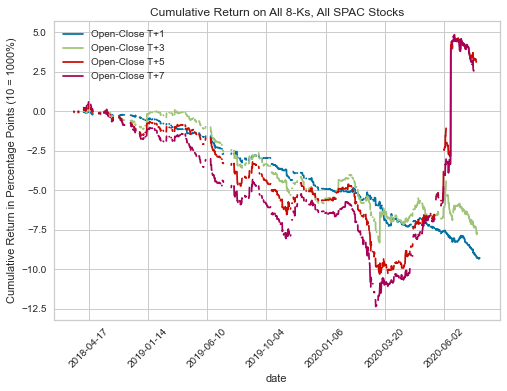

In [79]:
df_returns_all = df_returns_past.append(df_returns_current)
df_returns_all.sort_values(by='date', inplace=True)
df_returns_all.set_index('date')['open_close_t+1_%chg'].cumsum().plot(label='Open-Close T+1')
df_returns_all.set_index('date')['open_close_t+3_%chg'].cumsum().plot(label='Open-Close T+3')
df_returns_all.set_index('date')['open_close_t+5_%chg'].cumsum().plot(label='Open-Close T+5')
df_returns_all.set_index('date')['open_close_t+7_%chg'].cumsum().plot(label='Open-Close T+7')
plt.title('Cumulative Return on All 8-Ks, All SPAC Stocks');
plt.ylabel('Cumulative Return in Percentage Points (10 = 1000%)');
plt.xticks(rotation=45);
plt.legend();

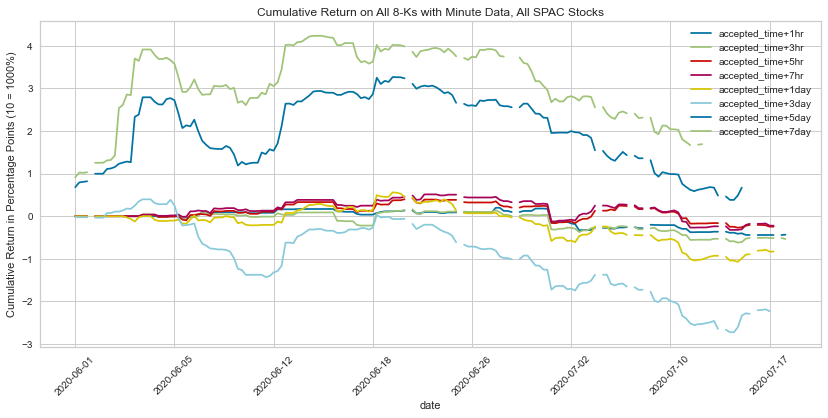

In [80]:
df_returns_all_stocks_minute.sort_values(by='accepted_time', inplace=True)
plt.figure(figsize=(14,6));
df_returns_all_stocks_minute.set_index('accepted_time')['accepted_time_t+1hr_%chg'].cumsum().plot(label='accepted_time+1hr')
df_returns_all_stocks_minute.set_index('accepted_time')['accepted_time_t+3hr_%chg'].cumsum().plot(label='accepted_time+3hr')
df_returns_all_stocks_minute.set_index('accepted_time')['accepted_time_t+5hr_%chg'].cumsum().plot(label='accepted_time+5hr')
df_returns_all_stocks_minute.set_index('accepted_time')['accepted_time_t+7hr_%chg'].cumsum().plot(label='accepted_time+7hr')
df_returns_all_stocks_minute.set_index('date')['accepted_time_t+1_%chg'].cumsum().plot(label='accepted_time+1day')
df_returns_all_stocks_minute.set_index('date')['accepted_time_t+3_%chg'].cumsum().plot(label='accepted_time+3day')
df_returns_all_stocks_minute.set_index('date')['accepted_time_t+5_%chg'].cumsum().plot(label='accepted_time+5day')
df_returns_all_stocks_minute.set_index('date')['accepted_time_t+7_%chg'].cumsum().plot(label='accepted_time+7day')
plt.title('Cumulative Return on All 8-Ks with Minute Data, All SPAC Stocks');
plt.ylabel('Cumulative Return in Percentage Points (10 = 1000%)');
plt.xticks(rotation=45);
plt.legend();

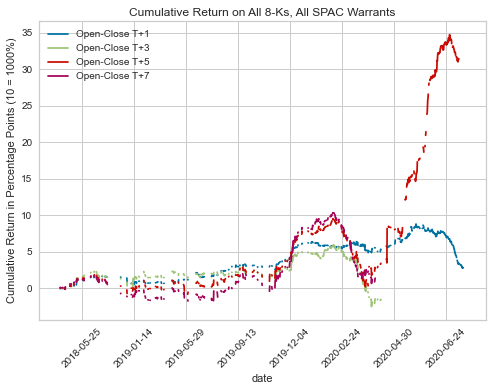

In [81]:
df_returns_all_warrants = df_returns_past_warrants_newticker.append(df_returns_current_warrants)
df_returns_all_warrants.sort_values(by='date', inplace=True)
df_returns_all_warrants.set_index('date')['open_close_t+1_%chg'].cumsum().plot(label='Open-Close T+1')
df_returns_all_warrants.set_index('date')['open_close_t+3_%chg'].cumsum().plot(label='Open-Close T+3')
df_returns_all_warrants.set_index('date')['open_close_t+5_%chg'].cumsum().plot(label='Open-Close T+5')
df_returns_all_warrants.set_index('date')['open_close_t+7_%chg'].cumsum().plot(label='Open-Close T+7')
plt.title('Cumulative Return on All 8-Ks, All SPAC Warrants');
plt.ylabel('Cumulative Return in Percentage Points (10 = 1000%)');
plt.xticks(rotation=45);
plt.legend();

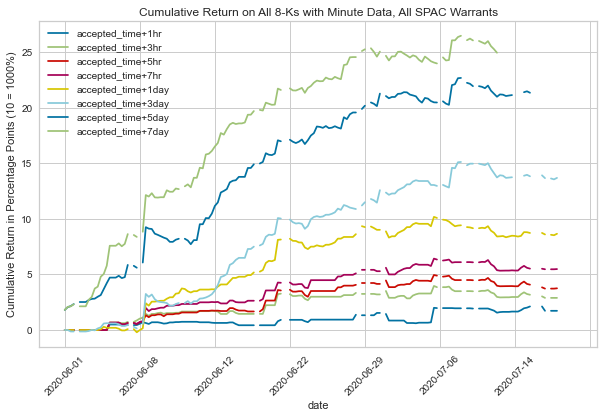

In [82]:
df_returns_all_warrants_minute.sort_values(by='accepted_time', inplace=True)
plt.figure(figsize=(10,6));
df_returns_all_warrants_minute.set_index('accepted_time')['accepted_time_t+1hr_%chg'].cumsum().plot(label='accepted_time+1hr')
df_returns_all_warrants_minute.set_index('accepted_time')['accepted_time_t+3hr_%chg'].cumsum().plot(label='accepted_time+3hr')
df_returns_all_warrants_minute.set_index('accepted_time')['accepted_time_t+5hr_%chg'].cumsum().plot(label='accepted_time+5hr')
df_returns_all_warrants_minute.set_index('accepted_time')['accepted_time_t+7hr_%chg'].cumsum().plot(label='accepted_time+7hr')
df_returns_all_warrants_minute.set_index('date')['accepted_time_t+1_%chg'].cumsum().plot(label='accepted_time+1day')
df_returns_all_warrants_minute.set_index('date')['accepted_time_t+3_%chg'].cumsum().plot(label='accepted_time+3day')
df_returns_all_warrants_minute.set_index('date')['accepted_time_t+5_%chg'].cumsum().plot(label='accepted_time+5day')
df_returns_all_warrants_minute.set_index('date')['accepted_time_t+7_%chg'].cumsum().plot(label='accepted_time+7day')
plt.title('Cumulative Return on All 8-Ks with Minute Data, All SPAC Warrants');
plt.ylabel('Cumulative Return in Percentage Points (10 = 1000%)');
plt.xticks(rotation=45);
plt.legend();

# Predict warrants return using 8-K content

In [331]:
def remove_header_footer(text):
    # remove/replace some unicode characters
    text = text.replace('\t','')
    text = text.replace('\x93','"')
    text = text.replace('\x94','"')
    text = text.replace('”', '"') # weird unicode/ascii conversion issue
    text = text.replace('“', '"') # weird unicode/ascii conversion issue
    
    # remove everything in header and footer
    ind_start = text.find('financial accounting standards provided pursuant to section 13(a) of the exchange act')
    ind_end = text.find('signature pursuant to the requirements of the securities exchange act of 1934')
    text = text[ind_start:ind_end]
    
    # remove forward looking statement section
    forward_looking_statement_start = ['forward-looking statements this current report',
                                       'forward looking statements certain statements',
                                       'forward-looking statements this report',
                                       'forward-looking statements the company makes',
                                       'forward-looking statements certain of the matters',
                                       'forward-looking statements this communication']
    forward_looking_statement_end = ['undue reliance should not be placed upon the forward-looking statements',
                                     'whether as a result of new information, future events or otherwise, except as required by law',
                                     'conditions or circumstances on which any such statement is based, except as required by applicable law']
    for forward_start in forward_looking_statement_start:
        for forward_end in forward_looking_statement_end:
            ind_start = text.find(forward_start)
            ind_end = text.find(forward_end)
            if ind_start!=-1 and ind_end!=-1:
                text = text[0:ind_start] + text[ind_end+len(forward_end):]
    
    # additional text to remove
    text_to_remove = [
        'financial accounting standards provided pursuant to section 13(a) of the exchange act'
    ]
    for rm in text_to_remove:
        text = text.replace(rm,'')
    
    return text

def get_item_subheaders(text, subheaders_only):
    subheaders = re.findall('item [0-9]+\.[0-9]+', text)
    subheaders = list(collections.OrderedDict.fromkeys(subheaders)) # handle cases where subheader mentioned in content
    subtexts = []
    for i in range(0,len(subheaders)):
        if i+1==len(subheaders):
            subtext = text[text.find(subheaders[i]):]
        else:
            subtext = text[text.find(subheaders[i]):text.find(subheaders[i+1])]
        if 'item 9.01 financial statements and exhibits' in subtext:
            continue
        else:
            subtexts.append(subtext)
    
    # drop these items
    drop_item_list = ['item 9.01']
    
    if subheaders_only:
        return [x for x in subheaders if x not in drop_item_list]
    return subtexts

def count_keywords(x, keywords):
    count = 0
    for keyword in keywords:
        count = count + x.count(keyword)
    return count

def text_processing(text, item_features, stemming=True):
    subtexts = get_item_subheaders(text, subheaders_only=False)
    tokens = []
    for subtext in subtexts:
        # remove item subheaders. todo: probably should remove text of subheader too
        for item in item_features:
            subtext = subtext.replace(item,'')

        # tokenize, only keeping alphanumeric
        subtokens = nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(subtext)

        # remove stop words
        stop_words = set(nltk.corpus.stopwords.words('english'))
        subtokens = [w for w in subtokens if not w in stop_words]

        # remove numbers and chinese/other non-english characters for now
        # (todo: revisit later for vote count processing)
        subtokens = [w for w in subtokens if w.encode('utf-8').isalpha()]

        # stemming
        if stemming:
            stems = [nltk.stem.porter.PorterStemmer().stem(w) for w in subtokens]
            tokens.extend(stems)
        else:
            tokens.extend(subtokens)

    processed_text = ' '.join(tokens)
    return processed_text

def add_subheader_item_features(df_ret, item_features):
    # item definitions: https://www.sec.gov/fast-answers/answersform8khtm.html
    # item faq: https://media2.mofo.com/documents/faq-form-8-k.pdf
    for col in item_features:
        df_ret[col] = 0
    for i in range(0, len(df_ret)):
        text = df_ret.loc[i]['text']
        items = get_item_subheaders(text, subheaders_only=True)
        for item in items:
            df_ret.loc[i,item] = 1
    return df_ret

def add_bagofwords_features(df_ret, vectorizer_type, response_variable):
    # process text and create bigram, trigram features
    corpus = []
    for text in df_ret['text']:
        corpus.append(text_processing(text))
    print('vectorizer:', vectorizer_type, '\n')
    if vectorizer_type=='CountVectorizer':
        vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 3)) # Total Frequency
    elif vectorizer_type=='TfidfVectorizer':
        vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(2, 3)) # TF-IDF
    else:
        print('vectorizer_type d.n.e')
    X_corpus = vectorizer.fit_transform(corpus)
    df_bagofwords = pd.DataFrame(X_corpus.toarray())
    df_bagofwords.columns = vectorizer.get_feature_names()
    
    # concatenate
    df_ret = pd.concat([df_ret, df_bagofwords], axis=1)

    # example features
    print('letter intent features:', [x for x in df_bagofwords.columns if 'letter intent' in x])

    # histogram
    (n, bins, patches) = plt.hist(df_ret[response_variable], bins=10, label=response_variable)
    plt.title('Histogram of ' + response_variable)
    plt.show()
    print('bins', np.round(bins,2))
    print('counts', n)
    
    return df_ret

def convert_vote_count_to_int(x):
    if '—' in x or '-' in x or 'n/a' in x:
        return 0
    try:
        x = int(x.replace(',',''))
    except:
        return np.nan
    return x

# does not handle: https://www.sec.gov/Archives/edgar/data/1704760/000161577419006723/s117785_8k.htm (no broker non-votes)
def parse_vote_results(x):
    vote_string = 'for against abstain broker non-votes'
    ind_vote = x['text'].find(vote_string)
    if ind_vote == -1:
        vote_string = 'for against abstain broker non-vote'
        ind_vote = x['text'].find(vote_string)
    if ind_vote == -1:
        vote_string = 'for against abstention broker non-votes'
        ind_vote = x['text'].find(vote_string)
    if ind_vote == -1:
        vote_string = 'for against abstention broker non-vote'
        ind_vote = x['text'].find(vote_string)
    if ind_vote == -1:
        vote_string = 'for against abstentions broker non-votes'
        ind_vote = x['text'].find(vote_string)
    if ind_vote == -1:
        vote_string = 'for against abstentions broker non-vote'
        ind_vote = x['text'].find(vote_string)
    if ind_vote != -1:
        text_split = x['text'][(ind_vote+len(vote_string)):].lstrip().split(' ')
        votes_for = convert_vote_count_to_int(text_split[0])
        votes_against = convert_vote_count_to_int(text_split[1])
        votes_abstain = convert_vote_count_to_int(text_split[2])
        votes_broker_non_votes = convert_vote_count_to_int(text_split[3])
        if np.isnan(votes_for) or np.isnan(votes_against) or np.isnan(votes_abstain) or np.isnan(votes_broker_non_votes):
            print('something wrong with parse_vote_results for', x.symbol, 'on', x.date)
        return pd.Series([votes_for, votes_against, votes_abstain, votes_broker_non_votes])
    return pd.Series([np.nan, np.nan, np.nan, np.nan])

def parse_redemptions(x):
    string_redemption_1 = 'in connection with the extension'
    string_redemption_2 = 'in connection with the closing'
    string_redemption_3 = 'in advance of the special meeting'
    string_redemption_4 = 'in connection with the special meeting'
    redemption_sentence = [sentence for sentence in x.text.split('.') if
                           string_redemption_1 in sentence
                           and ('redeem' in sentence or 'redemp' in sentence)]
    if len(redemption_sentence)==0:
        redemption_sentence = [sentence for sentence in x.text.split('.') if
                               string_redemption_2 in sentence
                               and ('redeem' in sentence or 'redemp' in sentence)]
    if len(redemption_sentence)==0:
        redemption_sentence = [sentence for sentence in x.text.split('.') if
                               string_redemption_3 in sentence
                               and ('redeem' in sentence or 'redemp' in sentence)]
    if len(redemption_sentence)==0:
        redemption_sentence = [sentence for sentence in x.text.split('.') if
                               string_redemption_4 in sentence
                               and ('redeem' in sentence or 'redemp' in sentence)]
    if len(redemption_sentence)==0:
        return np.nan
    redemption_sentence = redemption_sentence[0].lstrip().replace(',','')
    redemption_sentence = re.sub(r'[\$]{1}[\d,]+\.?\d{0,2}', '', redemption_sentence) # replace $_#_
    shares_regex_strong = re.findall('[0-9]+ shares', redemption_sentence)
    shares_regex_weak = re.findall('[0-9]+', redemption_sentence)
    # case: just one number in sentence. assume this number is redemption number
    if len(shares_regex_weak)==1:
        shares = int(shares_regex_weak[0])
    # case: more than one number in sentence. if '[0-9]+ shares' then assume this is redemption number, otherwise nan
    elif len(shares_regex_weak)>1:
        if len(shares_regex_strong)==1:
            shares = int(shares_regex_strong[0].replace('shares','').replace(' ',''))
        else:
            shares = np.nan
    # case: no numbers in sentence.
    else:
        if 'none' in redemption_sentence:
            shares = 0
        else:
            shares = np.nan
    return shares

def compute_self_engineered_feature_metrics(df_ret, col_name, response_variable):
    print('count', col_name, '> 0:', np.sum(df_ret[col_name]>0),
          '; count', response_variable, '> 0:', len(df_ret[df_ret[col_name]>0][df_ret[response_variable]>0]),
          '; count unique symbols:', len(df_ret[df_ret[col_name]>0]['symbol'].unique()))

def add_self_engineered_features(df_ret, response_variable=None):    
    # keywords lists
    keywords_list_loi = [
    'entry into a letter of intent',
    'entry into a non-binding letter of intent',
    'enter into a letter of intent',
    'enter into a non-binding letter of intent',
    'entered into a letter of intent',
    'entered into a non-binding letter of intent',
    'entering into a letter of intent',
    'entering into a non-binding letter of intent',
    'execution of a letter of intent',
    'execution of a non-binding letter of intent',
    'execute a letter of intent',
    'execute a non-binding letter of intent',
    'executed a letter of intent',
    'executed a non-binding letter of intent',
    'executing a letter of intent',
    'executing a non-binding letter of intent'
    ]
    keywords_list_business_combination_agreement = [
    '("business combination agreement")',
    '(the "business combination agreement")',
    '("business combination")',
    '(the "business combination")',
    'entry into a definitive agreement',
    'enter into a definitive agreement',
    'entered into a definitive agreement',
    'entering into a definitive agreement'
    ]
    keywords_list_merger_agreement = ['(the "merger agreement")']
    keywords_list_purchase_agreement = ['(the "purchase agreement")']
    keywords_list_extension = [
    '(the "extension")',
    '(the "extension amendment")'
    ]
    keywords_list_meeting = ['("special meeting")', '(the "meeting")']
    keywords_list_record = ['(the "record date")']
    keywords_list_consummation = [
    'announcing the consummation',
    'consummated the previously announced business combination'
    ]
    keywords_list_ipo = [
    'consummated its initial public offering ("ipo")',
    'consummated its initial public offering (the "ipo")',
    'consummated an initial public offering ("ipo")',
    'consummated an initial public offering (the "ipo")',
    'consummated the initial public offering ("ipo")',
    'consummated the initial public offering (the "ipo")',
    'completed its initial public offering ("ipo")',
    'completed its initial public offering (the "ipo")',
    'in connection with its initial public offering ("ipo") was declared effective',
    'in connection with its initial public offering (the "ipo") was declared effective'
    ]
    keywords_list_trust = [
    'trust account'
    ]
    
    # keywords counts
    df_ret['keywords_loi'] = df_ret.text.apply(lambda x: count_keywords(x, keywords_list_loi))
    df_ret['keywords_business_combination_agreement'] = df_ret.text.apply(lambda x: count_keywords(x, keywords_list_business_combination_agreement))
    df_ret['keywords_merger_agreement'] = df_ret.text.apply(lambda x: count_keywords(x, keywords_list_merger_agreement))
    df_ret['keywords_purchase_agreement'] = df_ret.text.apply(lambda x: count_keywords(x, keywords_list_purchase_agreement))
    df_ret['keywords_extension'] = df_ret.text.apply(lambda x: count_keywords(x, keywords_list_extension))
    df_ret['keywords_meeting'] = df_ret.text.apply(lambda x: count_keywords(x, keywords_list_meeting))
    df_ret['keywords_record'] = df_ret.text.apply(lambda x: count_keywords(x, keywords_list_record))
    df_ret['keywords_consummation'] = df_ret.text.apply(lambda x: count_keywords(x, keywords_list_consummation))
    df_ret['keywords_ipo'] = df_ret.text.apply(lambda x: count_keywords(x, keywords_list_ipo))
    df_ret['keywords_trust'] = df_ret.text.apply(lambda x: count_keywords(x, keywords_list_trust))
    
    # compute metrics
    if response_variable is not None:
        keywords_name_list = ['keywords_loi','keywords_business_combination_agreement','keywords_merger_agreement',
                              'keywords_purchase_agreement','keywords_extension','keywords_meeting','keywords_record',
                              'keywords_consummation','keywords_ipo','keywords_trust','item 5.07','item 3.01','item 2.03']
        for keywords_name in keywords_name_list:
            compute_self_engineered_feature_metrics(df_ret, keywords_name, response_variable)
#     display(df_ret[(df_ret['item 2.03']==1) & (df_ret['keywords_loi']==1)])
#     display(df_ret[(df_ret['item 2.03']==1) & (df_ret['keywords_business_combination_agreement']==1)])
#     display(df_ret[(df_ret['item 2.03']==1) & (df_ret['keywords_consummation']==1)])
#     display(df_ret[(df_ret['item 2.03']==1) & (df_ret['keywords_extension']==1)])

    # vote results
    df_ret['votes_for'] = np.nan
    df_ret['votes_against'] = np.nan
    df_ret['votes_abstain'] = np.nan
    df_ret['votes_broker_non_votes'] = np.nan
    df_ret[['votes_for', 'votes_against', 'votes_abstain', 'votes_broker_non_votes']] = df_ret.apply(lambda x: parse_vote_results(x), axis=1)
    df_ret['vote_total'] = df_ret['votes_for'] + df_ret['votes_against'] + df_ret['votes_abstain'] + df_ret['votes_broker_non_votes']
    df_ret['%votes_for'] = df_ret['votes_for'] / df_ret['vote_total']
    df_ret['%vote_against'] = df_ret['votes_against'] / df_ret['vote_total']
    df_ret['%votes_abstain'] = df_ret['votes_abstain'] / df_ret['vote_total']
    df_ret['%votes_broker_non_votes'] = df_ret['votes_broker_non_votes'] / df_ret['vote_total']
    
    # shares redeemed
    df_ret['redeemed_shares'] = df_ret.apply(lambda x: parse_redemptions(x), axis=1)
    df_ret['%redeemed'] = df_ret['redeemed_shares'] / df_ret['vote_total']
    
    return df_ret

# Useful text:
# "Item 7.01 Regulation FD Disclosure": LOI, Business Combination Agreement, Business Combination consummation
# "Item 5.07 Submission of Matters to a Vote of Security Holders": vote extension, vote result
# key words LOI: definitive agreement, letter of intent
# key words business combination agreement: "business combination agreement", "business combination", "merger agreement", "purchase agreement"
# key words vote: ("special meeting"), (the "meeting"), (the "extension"), (the "extension amendment"), (the "record date")
# key words other: (the "closing date")

# Not useful:
# dropped "item 9.01 financial statements and exhibits"
# maybe drop "Forward-Looking Statements", "No Offer or Solicitation"
# maybe drop "Item 5.02. Departure of Directors or Certain Officers; Election of Directors; Appointment of Certain Officers; Compensatory Arrangements of Certain Officers."

# other notes:
# 8-Ks aren't actually iid, maybe symbols with previous positive reactions are more likely to positive
#    - example of bad reaction KXIN Form 25 https://www.sec.gov/Archives/edgar/data/1713539/000135445719000234/0001354457-19-000234-index.htm
#    - another example: NSCO Form 25 https://www.sec.gov/Archives/edgar/data/1709682/000087666119000802/0000876661-19-000802-index.htm
# stratify by sector
# add class weight instead of cv with f1 score
# maybe create set of features using all legal terms in (), e.g. (the "special meeting")

In [332]:
# data processing inputs
y_variable = 'open_close_t+5_%chg' # t+1, t+3, t+5, or t+7

# get all warrants and drop nan and corrupt symbols
# todo: merge newticker and oldticker df_returns_past_warrants properly. use newticker for now
df_returns_warrants = df_returns_past_warrants_newticker.append(df_returns_current_warrants)
df_returns_warrants.drop(columns=['letter_of_intent_found',
                                  'business_combination_agreement_found',
                                  'form'], inplace=True)

print('count 8-Ks:', len(df_returns_warrants))
df_returns_warrants.dropna(inplace=True)
print('count 8-Ks after dropping nan prices:', len(df_returns_warrants))
# remove corrupt symbols
df_returns_warrants = df_returns_warrants[~df_returns_warrants.symbol.isin(['ACELW','LAZYW'])]
print('count 8-Ks after dropping corrupt symbols:', len(df_returns_warrants), '\n')
df_returns_warrants.sort_values(by='accepted_time', inplace=True) # need to sort for TimeSeriesSplit
df_returns_warrants.reset_index(inplace=True, drop=True)

print('predicting:', y_variable)

# define item features
item_features = ['item 1.01','item 1.02','item 1.03','item 1.04','item 2.01','item 2.02','item 2.03','item 2.04',
                 'item 2.05','item 2.06','item 3.01','item 3.02','item 3.03','item 4.01','item 4.02','item 5.01',
                 'item 5.02','item 5.03','item 5.04','item 5.05','item 5.06','item 5.07','item 5.08','item 6.01',
                 'item 6.02','item 6.03','item 6.04','item 6.05','item 7.01','item 8.01']

# remove header and footer
df_returns_warrants['text'] = df_returns_warrants.text.apply(lambda x: remove_header_footer(x))

# add subheader item binary features
df_returns_warrants = add_subheader_item_features(df_ret=df_returns_warrants, item_features=item_features)

# add bag of words features
# df_returns_warrants = add_bagofwords_features(df_ret=df_returns_warrants,
#                                               vectorizer_type='CountVectorizer', # CountVectorizer or TfidfVectorizer
#                                               response_variable=y_variable)

# add self engineered features
df_returns_warrants = add_self_engineered_features(df_ret=df_returns_warrants, response_variable=y_variable)

count 8-Ks: 1713
count 8-Ks after dropping nan prices: 685
count 8-Ks after dropping corrupt symbols: 661 

predicting: open_close_t+5_%chg
count keywords_loi > 0: 11 ; count open_close_t+5_%chg > 0: 6 ; count unique symbols: 9
count keywords_business_combination_agreement > 0: 103 ; count open_close_t+5_%chg > 0: 48 ; count unique symbols: 35
count keywords_merger_agreement > 0: 26 ; count open_close_t+5_%chg > 0: 14 ; count unique symbols: 14
count keywords_purchase_agreement > 0: 24 ; count open_close_t+5_%chg > 0: 6 ; count unique symbols: 11
count keywords_extension > 0: 42 ; count open_close_t+5_%chg > 0: 24 ; count unique symbols: 20
count keywords_meeting > 0: 29 ; count open_close_t+5_%chg > 0: 11 ; count unique symbols: 16
count keywords_record > 0: 5 ; count open_close_t+5_%chg > 0: 1 ; count unique symbols: 5
count keywords_consummation > 0: 13 ; count open_close_t+5_%chg > 0: 6 ; count unique symbols: 10
count keywords_ipo > 0: 4 ; count open_close_t+5_%chg > 0: 1 ; count 

strings match: ['entry into a letter of intent', 'entry into a non-binding letter of intent', 'entered into a letter of intent', 'entered into a non-binding letter of intent', 'entering into a letter of intent', 'entering into a non-binding letter of intent', 'execute a letter of intent', 'execute a non-binding letter of intent', 'executed a letter of intent', 'executed a non-binding letter of intent', 'executing a letter of intent', 'executing a non-binding letter of intent', 'execution of a letter of intent', 'execution of a non-binding letter of intent'] 

count 8-Ks matched: 10


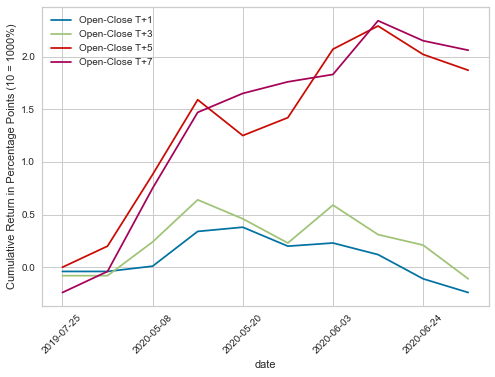

strings match: ['("business combination agreement")', '(the "business combination agreement")', '("business combination")', '(the "business combination")', 'entry into a definitive agreement', 'enter into a definitive agreement', 'entered into a definitive agreement', 'entering into a definitive agreement', 'business combination proposal was approved'] 

count 8-Ks matched: 126


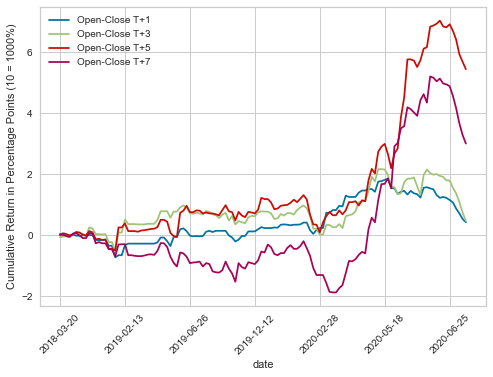

strings match: ['(the "extension")', '(the "extension amendment")'] 

count 8-Ks matched: 36


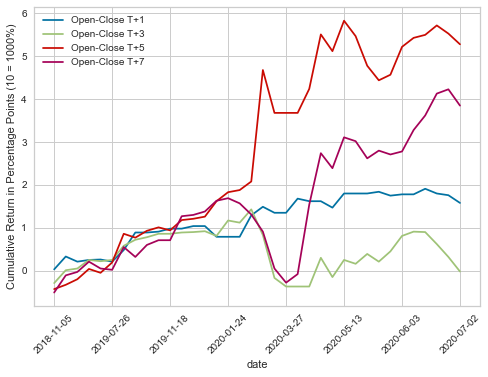

strings match: ['announcing the consummation', 'consummated the previously announced business combination', 'consummated the remainder of the transactions contemplated by the business combination', 'consummation of the transactions'] 

count 8-Ks matched: 47


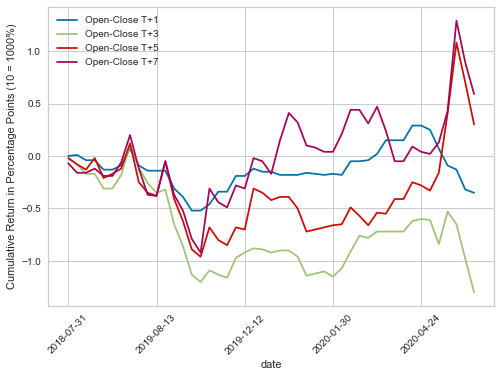

strings match: ['form of presentation', 'furnished an investor presentation', 'updated investor presentation', 'investor presentation are furnished', 'form of investor presentation', 'update the investor presentation'] 

count 8-Ks matched: 25


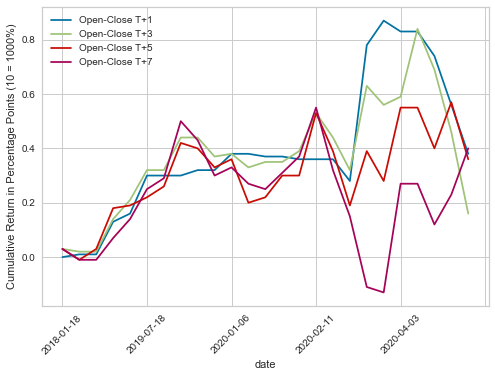

strings match: ['investor presentation'] 

count 8-Ks matched: 99


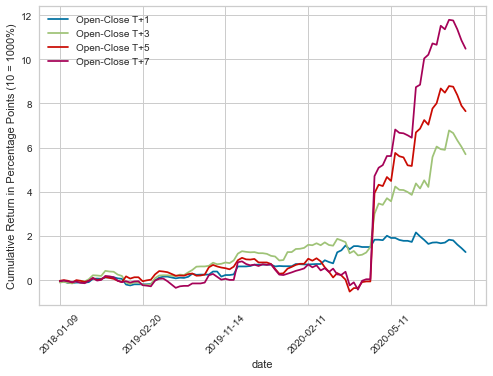

strings match: ['(the "trust account")', '(the "contribution")', '(the "revised contribution")'] 

count 8-Ks matched: 14


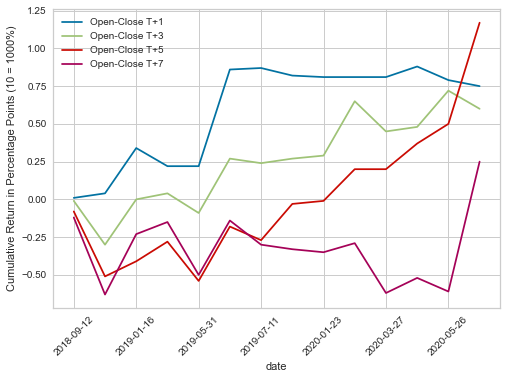

strings match: ['trust account'] 

count 8-Ks matched: 92


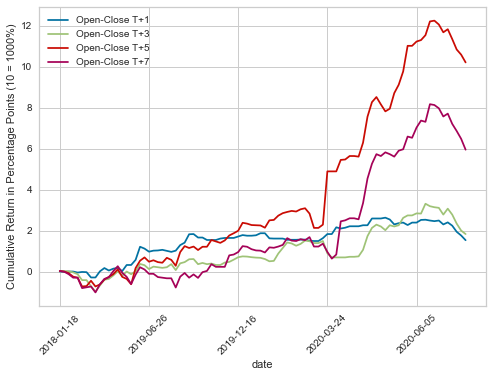

strings match: ['form 25'] 

count 8-Ks matched: 4


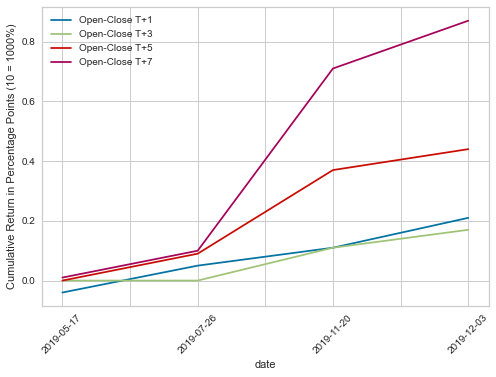

strings match: ['consummated its initial public offering ("ipo")', 'consummated its initial public offering (the "ipo")', 'consummated an initial public offering ("ipo")', 'consummated an initial public offering (the "ipo")', 'consummated the initial public offering ("ipo")', 'consummated the initial public offering (the "ipo")', 'completed its initial public offering ("ipo")', 'completed its initial public offering (the "ipo")', 'in connection with its initial public offering ("ipo") was declared effective', 'in connection with its initial public offering (the "ipo") was declared effective'] 

count 8-Ks matched: 0


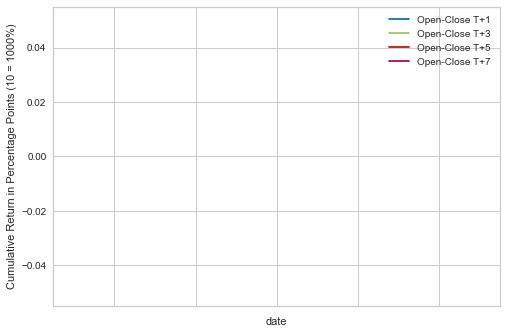

In [333]:
# study different keywords

def string_match_test(test_strings):
    print('strings match:', test_strings, '\n')
    df_matched = df_returns_warrants[(df_returns_warrants.text.str.contains('|'.join(test_strings))) &
                                     (df_returns_warrants['item 2.03']==0)]
    print('count 8-Ks matched:', len(df_matched))
    df_matched.set_index('date')['open_close_t+1_%chg'].cumsum().plot(label='Open-Close T+1')
    df_matched.set_index('date')['open_close_t+3_%chg'].cumsum().plot(label='Open-Close T+3')
    df_matched.set_index('date')['open_close_t+5_%chg'].cumsum().plot(label='Open-Close T+5')
    df_matched.set_index('date')['open_close_t+7_%chg'].cumsum().plot(label='Open-Close T+7')
    plt.ylabel('Cumulative Return in Percentage Points (10 = 1000%)');
    plt.xticks(rotation=45);
    plt.legend();
    plt.show();

# loi
string_match_test(test_strings=[
    'entry into a letter of intent',
    'entry into a non-binding letter of intent',
    'entered into a letter of intent',
    'entered into a non-binding letter of intent',
    'entering into a letter of intent',
    'entering into a non-binding letter of intent',
    'execute a letter of intent',
    'execute a non-binding letter of intent',
    'executed a letter of intent',
    'executed a non-binding letter of intent',
    'executing a letter of intent',
    'executing a non-binding letter of intent',
    'execution of a letter of intent',
    'execution of a non-binding letter of intent',
])
    
# bca
string_match_test(test_strings=[
    '("business combination agreement")',
    '(the "business combination agreement")',
    '("business combination")',
    '(the "business combination")',
    'entry into a definitive agreement',
    'enter into a definitive agreement',
    'entered into a definitive agreement',
    'entering into a definitive agreement',
    'business combination proposal was approved',
#     'entered into a stock and unit purchase agreement',
#     'entered into a securities purchase agreement',
#     'entered into an agreement and plan of merger',
#     'entered into a share exchange agreement',
])

# extension
string_match_test(test_strings=[
    '(the "extension")',
    '(the "extension amendment")',
])

# consummation
string_match_test(test_strings=[
    'announcing the consummation',
    'consummated the previously announced business combination',
    'consummated the remainder of the transactions contemplated by the business combination',
    'consummation of the transactions',
])
                  
# investor presentation
string_match_test(test_strings=[
    'form of presentation',
    'furnished an investor presentation',
    'updated investor presentation',
    'investor presentation are furnished',
    'form of investor presentation',
    'update the investor presentation',
])
string_match_test(test_strings=[ # this could be a good one
    'investor presentation'
])

# trust account
string_match_test(test_strings=[
    '(the "trust account")',
    '(the "contribution")',
    '(the "revised contribution")',
])
string_match_test(test_strings=[ # this could be a good one
    'trust account',
])

# form 25-nse
string_match_test(test_strings=[ # expect this to be a sell signal
    'form 25',
])

# consummate IPO
string_match_test(test_strings=[
    'consummated its initial public offering ("ipo")',
    'consummated its initial public offering (the "ipo")',
    'consummated an initial public offering ("ipo")',
    'consummated an initial public offering (the "ipo")',
    'consummated the initial public offering ("ipo")',
    'consummated the initial public offering (the "ipo")',
    'completed its initial public offering ("ipo")',
    'completed its initial public offering (the "ipo")',
    'in connection with its initial public offering ("ipo") was declared effective',
    'in connection with its initial public offering (the "ipo") was declared effective',
])

In [334]:
# randomly sample 8-Ks for populating test cases
# path_saved_8K = 'data/sec_filings_df'
# files_8Ks = [f for f in os.listdir(path_saved_8K) if os.path.isfile(os.path.join(path_saved_8K, f))]
# df_8Ks = pd.DataFrame()
# for file in files_8Ks:
#     df_8K = pd.read_csv(path_saved_8K+'/'+file)
#     df_8K['symbol'] = file.split('_')[0]
#     df_8Ks = df_8Ks.append(df_8K)
# df_8Ks.drop_duplicates(subset=['date','accepted_time','text'], inplace=True)
# df_8Ks.reset_index(drop=True, inplace=True)
# R = np.random.RandomState(123)
# random_inds = R.random_integers(0, len(df_8Ks), 110)
# df_8Ks[df_8Ks.index.isin(random_inds[100:110])]

# check single test case
# spac_list_temp = process_current_spacs(file_path_current='data/spac_list_temp.csv', write=False)
# temp = get_forms_text(company_name=spac_list_temp.title[0], cik_id=spac_list_temp.cik[0], form_type='8-K')
# temp['symbol'] = spac_list_temp.ticker[0]
# temp['text'] = temp.text.apply(lambda x: remove_header_footer(x))
# temp = add_subheader_item_features(df_ret=temp, item_features=item_features)
# temp = add_self_engineered_features(df_ret=temp)
# display(temp.head(1))

#### Binary Classification

In [335]:
def apply_lsa_dim_reduction(X, n_lsa):
    lsa = TruncatedSVD(n_components=n_lsa, n_iter=10, random_state=123)
    X = pd.DataFrame(lsa.fit_transform(X), columns=['lsa'+str(i) for i in range(0,n_lsa)])
    print('count feature after LSA:', len(X.columns), '\n')
    return X

def binary_classification_eval_metrics(y_actual, y_pred):
    print('% predicted positive labels:', np.round(sum(y_pred)/len(y_pred), 2))
    print('% actual positive labels:', np.round(sum(y_actual)/len(y_actual), 2))
    cm = confusion_matrix(y_actual, y_pred)
    print('confusion matrix:\n', cm)
    print(classification_report(y_actual, y_pred, target_names=['0','1']))

def binary_classification_report(model, X_train, X_test, y_train, y_test, feature_importance=True):
    print('############\nTraining set\n############')
    y_train_pred = model.predict(X_train)
    binary_classification_eval_metrics(y_train, y_train_pred)
    metrics.plot_roc_curve(model, X_train, y_train);
    plt.title('ROC curve (train)')
    plt.show()
    metrics.plot_precision_recall_curve(model, X_train, y_train)
    plt.title('Precision-recall curve (train)');
    plt.show()
    
    print('#########\nTest set\n#########')
    y_test_pred = model.predict(X_test)
    binary_classification_eval_metrics(y_test, y_test_pred)
    metrics.plot_roc_curve(model, X_test, y_test);
    plt.title('ROC curve (test)')
    plt.show()
    metrics.plot_precision_recall_curve(model, X_test, y_test)
    plt.title('Precision-recall curve (test)');
    plt.show()
    
    print('#########\nAll data\n#########')
    y_all_pred = model.predict(X)
    binary_classification_eval_metrics(y, y_all_pred)
    metrics.plot_roc_curve(model, X, y);
    plt.title('ROC curve (all)')
    plt.show()
    metrics.plot_precision_recall_curve(model, X, y)
    plt.title('Precision-recall curve (all)');
    plt.show()
    
    # feature importance
    if feature_importance:
        try:
            coefs = model.coef_[0]
        except:
            coefs = model.feature_importances_
        indices = np.argsort(np.abs(coefs))[::-1]
        count_nonzero_features = len(X.columns[coefs!=0])
        print('count nonzero features:', count_nonzero_features)
        if count_nonzero_features < 10:
            top_n_features = count_nonzero_features
        else:
            top_n_features = 10
        plt.bar(range(top_n_features), coefs[indices[:top_n_features]], align='center')
        plt.xticks(range(top_n_features), X.columns[indices[:top_n_features]], rotation=45, ha='right')
        plt.subplots_adjust(bottom=0.3)
        plt.title('Feature importance')
        plt.show()

In [336]:
# inputs
label_threshold = 0
min_word_freq = 0
n_lsa = None # None or int

# prep data
X = df_returns_warrants.drop(['open_close_t+1_%chg','open_close_t+3_%chg','open_close_t+5_%chg',
                              'open_close_t+7_%chg','symbol','date','accepted_time','text','url',
                              'votes_for','votes_against','votes_abstain','votes_broker_non_votes',
                              'vote_total','%votes_for','%votes_abstain','%votes_broker_non_votes',
                              'redeemed_shares'], axis=1)
X[['%vote_against','%redeemed']] = X[['%vote_against','%redeemed']].fillna(0)
print('count features:', len(X.columns))
X = X[X.columns[X.sum() >= min_word_freq].tolist()] # min word frequency
print('count features > min_word_freq:', len(X.columns))
if n_lsa is not None:
    X = apply_lsa_dim_reduction(X, n_lsa) # lsa dimension reduction
y = np.where(df_returns_warrants[y_variable] > label_threshold, 1, 0) # label threshold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
print('training dim:', X_train.shape)
print('testing dim:', X_test.shape, '\n')
print('count 0:', np.sum(y==0))
print('count 1:', np.sum(y==1))

count features: 42
count features > min_word_freq: 42
training dim: (528, 42)
testing dim: (133, 42) 

count 0: 356
count 1: 305


Naive rule based model

############
Training set
############
% predicted positive labels: 0.14
% actual positive labels: 0.46
confusion matrix:
 [[252  34]
 [201  41]]
              precision    recall  f1-score   support

           0       0.56      0.88      0.68       286
           1       0.55      0.17      0.26       242

    accuracy                           0.55       528
   macro avg       0.55      0.53      0.47       528
weighted avg       0.55      0.55      0.49       528

#########
Test set
#########
% predicted positive labels: 0.17
% actual positive labels: 0.47
confusion matrix:
 [[60 10]
 [50 13]]
              precision    recall  f1-score   support

           0       0.55      0.86      0.67        70
           1       0.57      0.21      0.30        63

    accuracy                           0.55       133
   macro avg       0.56      0.53      0.48       133
weighted avg       0.55      0.55      0.49       133

#########
All data
#########
% predicted pos

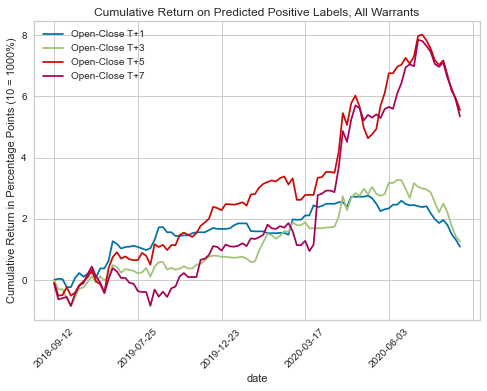

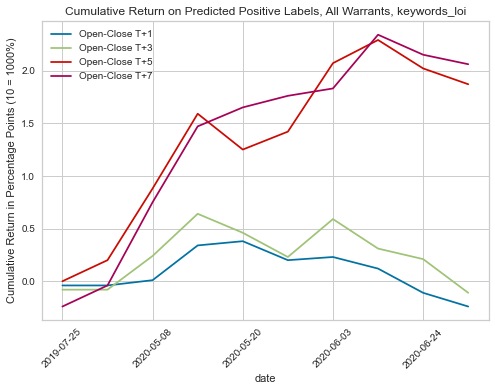

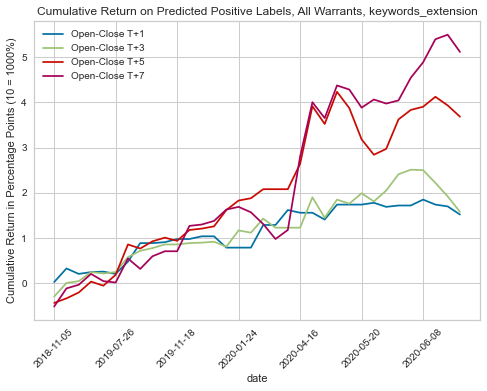

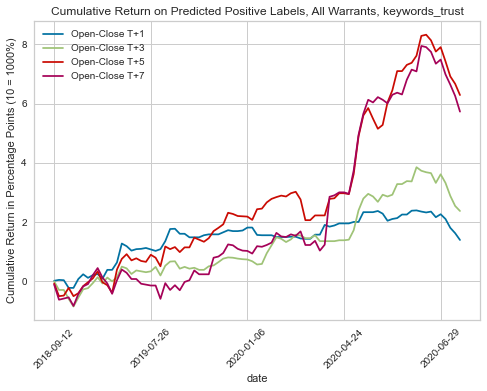

count keywords_loi > 0: 10 ; count open_close_t+5_%chg > 0: 6 ; count unique symbols: 9
count keywords_extension > 0: 34 ; count open_close_t+5_%chg > 0: 22 ; count unique symbols: 15
count keywords_trust > 0: 85 ; count open_close_t+5_%chg > 0: 47 ; count unique symbols: 39


In [339]:
print('Naive rule based model\n')

def naive_rule(x):
    if ~np.isnan(x['%vote_against']) and (x['%vote_against'] > .10):
        return 0
    elif x['keywords_ipo'] > 0:
        return 0
    else:
        if (x['keywords_loi'] > 0) and (x['item 2.03'] == 0):
            return 1
#         elif (x['keywords_business_combination_agreement'] > 0) and (x['item 2.03'] == 0):
#             return 1
#         elif (x['keywords_consummation'] > 0) and (x['item 2.03'] == 0):
#             return 1
        elif (x['keywords_extension'] > 0) and (x['item 2.03'] == 0):
            return 1
        elif (x['keywords_trust'] > 0) and (x['item 2.03'] == 0):
            return 1
        else:
            return 0

y_train_pred = X_train.apply(lambda x: naive_rule(x), axis=1)
y_test_pred = X_test.apply(lambda x: naive_rule(x), axis=1)
y_all_pred = X.apply(lambda x: naive_rule(x), axis=1)

print('############\nTraining set\n############')
binary_classification_eval_metrics(y_train, y_train_pred)

print('#########\nTest set\n#########')
binary_classification_eval_metrics(y_test, y_test_pred)

print('#########\nAll data\n#########')
binary_classification_eval_metrics(y, y_all_pred)
print('Count examples:', len(y))
print('Count positive labels:', y_all_pred.sum())
count_months = int(np.round((dt.strptime(df_returns_warrants.date.max(),'%Y-%m-%d') -
                             dt.strptime(df_returns_warrants.date.min(),'%Y-%m-%d')).days / 365. * 12, 0))
print('Count months:', count_months)
print('Trades / month:', np.round(y_all_pred.sum()/count_months, 1))

df_pred_pos = df_returns_warrants.loc[np.where(y_all_pred==1)[0],]
print(y_variable, 'sum:', np.round(df_pred_pos[y_variable].sum(), 2))
# todo: calculate sharpe and sortino ratios properly
print(y_variable, 'mean:', np.round(df_pred_pos[y_variable].mean(), 2))
print(y_variable, 'sd:', np.round(df_pred_pos[y_variable].std(), 2))
print(y_variable, 'downside sd:', np.round(df_pred_pos[y_variable][df_pred_pos[y_variable]<0].std(), 2))

df_pred_pos.set_index('date')['open_close_t+1_%chg'].cumsum().plot(label='Open-Close T+1')
df_pred_pos.set_index('date')['open_close_t+3_%chg'].cumsum().plot(label='Open-Close T+3')
df_pred_pos.set_index('date')['open_close_t+5_%chg'].cumsum().plot(label='Open-Close T+5')
df_pred_pos.set_index('date')['open_close_t+7_%chg'].cumsum().plot(label='Open-Close T+7')
plt.title('Cumulative Return on Predicted Positive Labels, All Warrants');
plt.ylabel('Cumulative Return in Percentage Points (10 = 1000%)');
plt.xticks(rotation=45);
plt.legend();
plt.show();

cols_plot = ['keywords_loi',
#              'keywords_business_combination_agreement',
#              'keywords_consummation',
             'keywords_extension',
             'keywords_trust']
for col in cols_plot:
    df_pred_pos[df_pred_pos[col]>0].set_index('date')['open_close_t+1_%chg'].cumsum().plot(label='Open-Close T+1')
    df_pred_pos[df_pred_pos[col]>0].set_index('date')['open_close_t+3_%chg'].cumsum().plot(label='Open-Close T+3')
    df_pred_pos[df_pred_pos[col]>0].set_index('date')['open_close_t+5_%chg'].cumsum().plot(label='Open-Close T+5')
    df_pred_pos[df_pred_pos[col]>0].set_index('date')['open_close_t+7_%chg'].cumsum().plot(label='Open-Close T+7')
    plt.title('Cumulative Return on Predicted Positive Labels, All Warrants, '+col);
    plt.ylabel('Cumulative Return in Percentage Points (10 = 1000%)');
    plt.xticks(rotation=45);
    plt.legend();
    plt.show();
    
# gini-like metric for predicted positive labels
keywords_name_list = ['keywords_loi','keywords_extension','keywords_trust']
for keywords_name in keywords_name_list:
    compute_self_engineered_feature_metrics(df_pred_pos, keywords_name, y_variable)

# todo: weird ones to look at
# GTYH: df_returns_warrants[df_returns_warrants.symbol=='GTYHW'].loc[115,'text']...somehow doesn't match up with https://www.sec.gov/Archives/edgar/data/1682325/000114420419014675/tv516340_8k12ba.htm

In [340]:
print('loi symbols:', df_returns_warrants[(df_returns_warrants.keywords_loi>0)].symbol.unique())
print('\nbusiness combination agreement symbols:', df_returns_warrants[(df_returns_warrants.keywords_business_combination_agreement>0)].symbol.unique())
print('\nextension symbols:', df_returns_warrants[(df_returns_warrants.keywords_extension>0)].symbol.unique())
print('\nconsummation symbols:', df_returns_warrants[(df_returns_warrants.keywords_consummation>0)].symbol.unique())
print('\ntrust symbols:', df_returns_warrants[(df_returns_warrants.keywords_trust>0)].symbol.unique())

loi symbols: ['PAACW' 'AVCTW' 'AMCIW' 'FMCIW' 'MFACW' 'SAMAW' 'OPESW' 'BMRGW' 'NFINW']

business combination agreement symbols: ['MGYW' 'PRTHW' 'WTRHW' 'THW' 'GTYHW' 'AVCTW' 'LHCW' 'KXINW' 'AESEW'
 'KERNW' 'ATCXW' 'ALACW' 'GTECW' 'BRMKW' 'KLRW' 'PACQW' 'NEBUW' 'HCCHW'
 'IMVTW' 'HYMCW' 'MNCLW' 'LACQW' 'GSMGW' 'NKLAW' 'PAACW' 'IMTXW' 'AMCIW'
 'FMCIW' 'MFACW' 'SAMAW' 'CCHW' 'OPESW' 'AHCOW' 'SHLLW' 'CRSAW']

extension symbols: ['GTYHW' 'AVCTW' 'AESEW' 'SPCEW' 'HOFVW' 'BRPAW' 'OPESW' 'PACQW' 'LACQW'
 'HCCHW' 'NEBUW' 'FMCIW' 'NKLAW' 'ALGRW' 'GRAFW' 'ALACW' 'MFACW' 'CFFAW'
 'SAMAW' 'LFACW']

consummation symbols: ['PRTHW' 'GRAFW' 'GTYHW' 'THW' 'PACKW' 'NSCOW' 'GTECW' 'AHCOW' 'BRMKW'
 'NKLAW']

trust symbols: ['THW' 'GTYHW' 'MFACW' 'GRAFW' 'AESEW' 'AVCTW' 'LHCW' 'KXINW' 'PACKW'
 'KERNW' 'SPCEW' 'RPAYW' 'PAACW' 'HOFVW' 'TOTAW' 'NSCOW' 'BRPAW' 'GSMGW'
 'OPESW' 'ALACW' 'ALGRW' 'KLRW' 'LACQW' 'MNCLW' 'NEBUW' 'HCCHW' 'IMVTW'
 'ACTTW' 'HYMCW' 'ATCXW' 'VVNTW' 'FMCIW' 'TZACW' 'LOACW' 'IMTXW' 'CCXXW'
 

In [341]:
df_pred_pos.groupby('symbol').agg({'accepted_time':'count'}).sort_values(by='accepted_time', ascending=False).head()

accepted_time
symbol               
HOFVW              11
AVCTW               8
LACQW               5
AESEW               5
OPESW               5

In [342]:
df_pred_pos.sort_values(by='open_close_t+3_%chg').head()

date  \
536  2020-05-12   
651  2020-06-30   
655  2020-07-02   
644  2020-06-29   
645  2020-06-29   

                                                                                                    text  \
536  . ¨ title of each class trading symbol(s) name of each exchange on which registered common stock...   
651  . ☐ item 1.01entry into a material definitive agreement. amendment to investment management trus...   
655  . ¨ item 7.01 regulation fd disclosure. on july 2, 2020, graf industrial corp. (the "company") i...   
644  .☐ item 1.01 entry into a material definitive agreement. on june 29, 2020, insurance acquisition...   
645  . ☐ item 7.01. regulation fd disclosure. on june 29, 2020, netfin acquisition corp. (the "compan...   

                                                                                                   url  \
536  https://www.sec.gov/Archives/edgar/data/1731289/000110465920060165/0001104659-20-060165-index.htm   
651  https://www.sec.gov/Archives/edgar/data/1716947/000121390020016355/0001213900-20-016355-index.htm   
655  https://www.sec.gov/Archives/edgar/data/1745317/000110465920080274/0001104659-20-080274-index.htm   
644  https://www.sec.gov/Archives/edgar/data/1762322/000121390020016030/0001213900-20-016030-index.htm   
645  https://www.sec.gov/Archives/edgar/data/1776903/000121390020016050/0001213900-20-016050-index.htm   

           accepted_time  open_close_t+1_%chg  open_close_t+3_%chg  \
536  2020-05-12 16:05:14                -0.15                -0.45   
651  2020-06-30 17:25:17                -0.30                -0.44   
655  2020-07-02 09:26:03                -0.18                -0.34   
644  2020-06-29 07:31:57                -0.19                -0.33   
645  2020-06-29 09:00:22                -0.13                -0.32   

     open_close_t+5_%chg  open_close_t+7_%chg symbol  item 1.01  item 1.02  \
536                -0.39                -0.35  NKLAW          0          0   
651                -0.51                -0.35  LACQW          1          0   
655                -0.25                -0.38  GRAFW          0          0   
644                -0.38                -0.40  INSUW          1          0   
645                -0.15                -0.09  NFINW          0          0   

     item 1.03  item 1.04  item 2.01  item 2.02  item 2.03  item 2.04  \
536          0          0          0          0          0          0   
651          0          0          0          0          0          0   
655          0          0          0          0          0          0   
644          0          0          0          0          0          0   
645          0          0          0          0          0          0   

     item 2.05  item 2.06  item 3.01  item 3.02  item 3.03  item 4.01  \
536          0          0          0          0          0          0   
651          0          0          0          0          0          0   
655          0          0          0          0          0          0   
644          0          0          0          1          0          0   
645          0          0          0          0          0          0   

     item 4.02  item 5.01  item 5.02  item 5.03  item 5.04  item 5.05  \
536          0          0          0          1          0          0   
651          0          1          0          1          0          0   
655          0          0          0          0          0          0   
644          0          0          0          0          0          0   
645          0          0          0          0          0          0   

     item 5.06  item 5.07  item 5.08  item 6.01  item 6.02  item 6.03  \
536          0          1          0          0          0          0   
651          0          1          0          0          0          0   
655          0          0          0          0          0          0   
644          0          0          0          0          0          0   
645          0          0          0  

Logistic Regression

Best 5-fold CV (TimeSeriesSplit) score: 0.461760 using {'C': 1} 



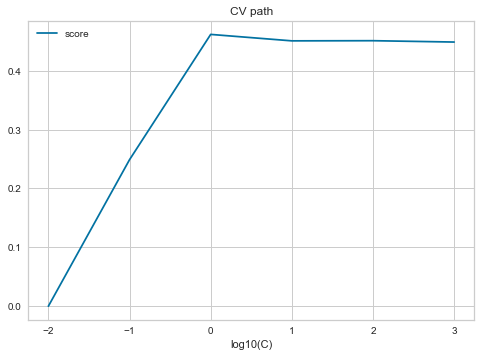

############
Training set
############
% predicted positive labels: 0.21
% actual positive labels: 0.46
confusion matrix:
 [[244  42]
 [174  68]]
              precision    recall  f1-score   support

           0       0.58      0.85      0.69       286
           1       0.62      0.28      0.39       242

    accuracy                           0.59       528
   macro avg       0.60      0.57      0.54       528
weighted avg       0.60      0.59      0.55       528



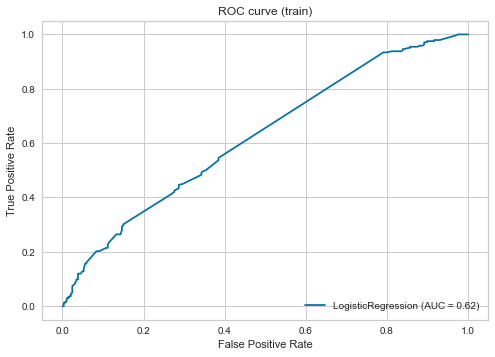

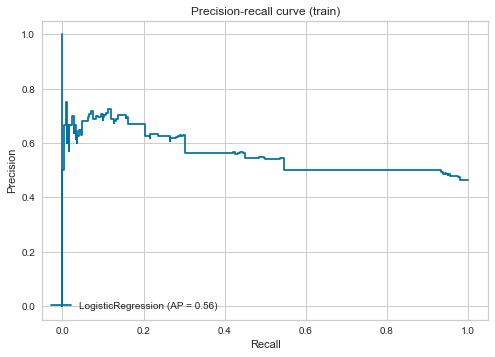

#########
Test set
#########
% predicted positive labels: 0.25
% actual positive labels: 0.47
confusion matrix:
 [[49 21]
 [51 12]]
              precision    recall  f1-score   support

           0       0.49      0.70      0.58        70
           1       0.36      0.19      0.25        63

    accuracy                           0.46       133
   macro avg       0.43      0.45      0.41       133
weighted avg       0.43      0.46      0.42       133



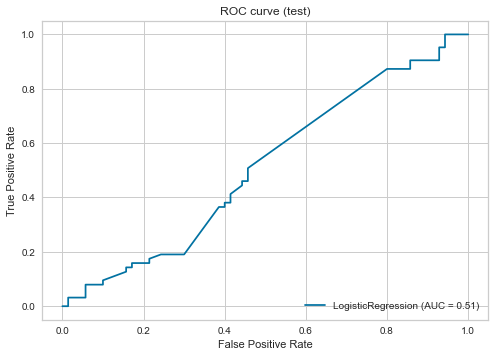

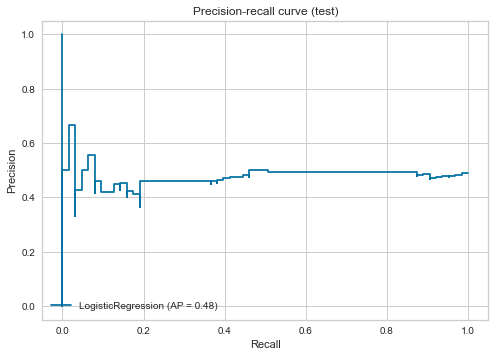

#########
All data
#########
% predicted positive labels: 0.22
% actual positive labels: 0.46
confusion matrix:
 [[293  63]
 [225  80]]
              precision    recall  f1-score   support

           0       0.57      0.82      0.67       356
           1       0.56      0.26      0.36       305

    accuracy                           0.56       661
   macro avg       0.56      0.54      0.51       661
weighted avg       0.56      0.56      0.53       661



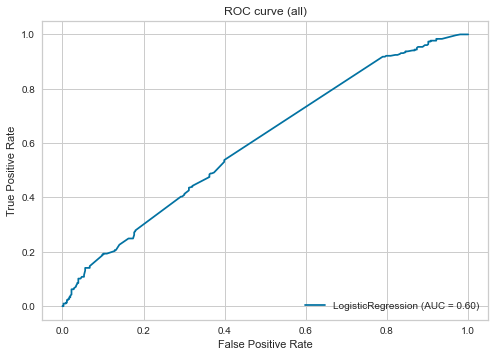

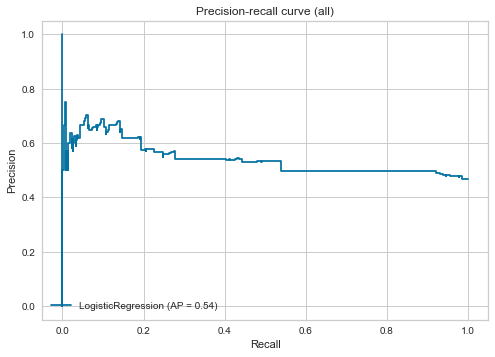

count nonzero features: 14


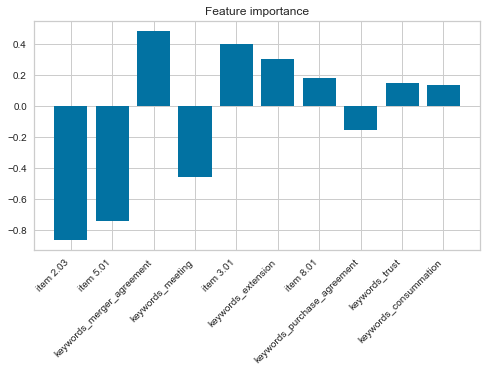

In [343]:
print('Logistic Regression\n')

# CV
model_lr = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
C = [.01, .1, 1, 10, 100, 1000]
# C = np.linspace(.5, 1.5, 10)
param_grid = dict(C=C)
kfold = TimeSeriesSplit(n_splits=5) # in each split test indices must be higher than before
grid_search = GridSearchCV(model_lr, param_grid, scoring='precision', cv=kfold, verbose=0, n_jobs=5)
grid_result = grid_search.fit(X_train, y_train)
print('Best 5-fold CV (TimeSeriesSplit) score: %f using %s' %
      (grid_result.best_score_, grid_result.best_params_), '\n')
reg_path = pd.DataFrame({'score': grid_result.cv_results_['mean_test_score'], 'C': C})
reg_path['C'] = np.log10(reg_path['C'])
reg_path.plot(x='C')
plt.title('CV path')
plt.xlabel('log10(C)')
plt.show()

# model
model_lr = LogisticRegression(penalty='l1', solver='liblinear', C=grid_result.best_params_['C'], max_iter=1000)
model_lr.fit(X_train, y_train)
binary_classification_report(model_lr, X_train, X_test, y_train, y_test)

Decision Tree

Best 5-fold CV (TimeSeriesSplit) score: 0.323189 using {'max_depth': 4} 



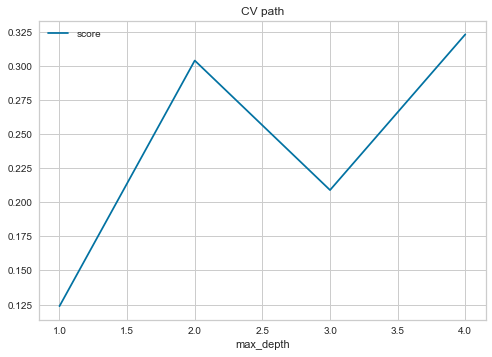

############
Training set
############
% predicted positive labels: 0.07
% actual positive labels: 0.46
confusion matrix:
 [[281   5]
 [210  32]]
              precision    recall  f1-score   support

           0       0.57      0.98      0.72       286
           1       0.86      0.13      0.23       242

    accuracy                           0.59       528
   macro avg       0.72      0.56      0.48       528
weighted avg       0.71      0.59      0.50       528



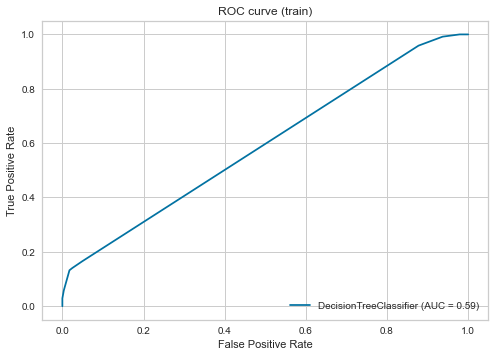

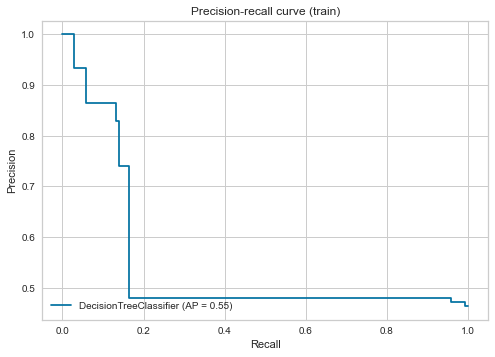

#########
Test set
#########
% predicted positive labels: 0.07
% actual positive labels: 0.47
confusion matrix:
 [[66  4]
 [58  5]]
              precision    recall  f1-score   support

           0       0.53      0.94      0.68        70
           1       0.56      0.08      0.14        63

    accuracy                           0.53       133
   macro avg       0.54      0.51      0.41       133
weighted avg       0.54      0.53      0.42       133



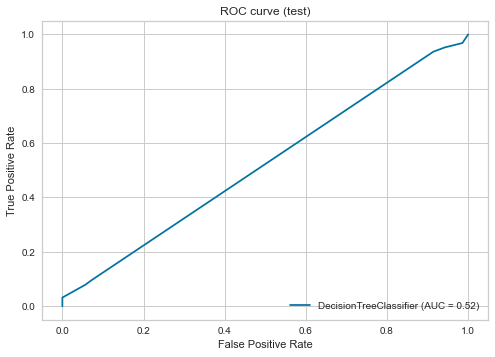

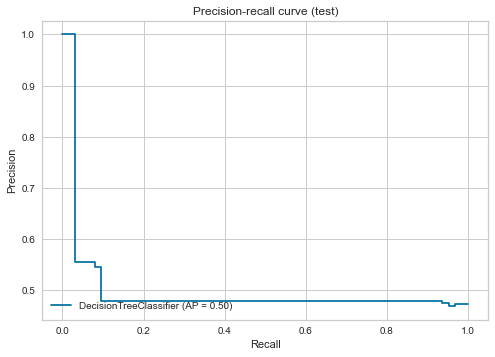

#########
All data
#########
% predicted positive labels: 0.07
% actual positive labels: 0.46
confusion matrix:
 [[347   9]
 [268  37]]
              precision    recall  f1-score   support

           0       0.56      0.97      0.71       356
           1       0.80      0.12      0.21       305

    accuracy                           0.58       661
   macro avg       0.68      0.55      0.46       661
weighted avg       0.68      0.58      0.48       661



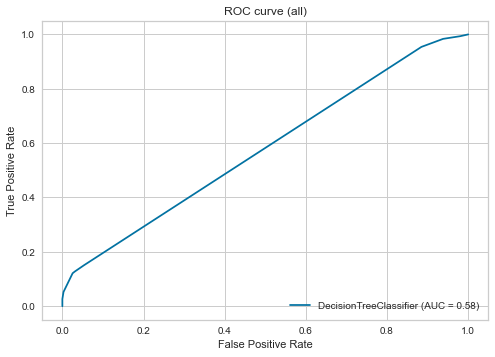

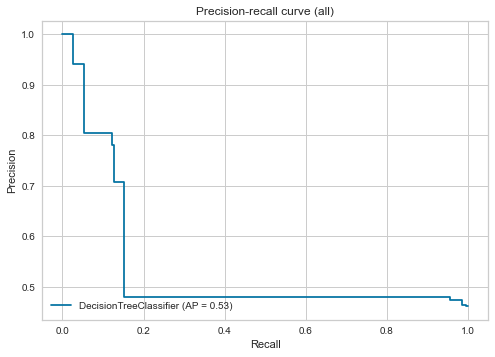

count nonzero features: 8


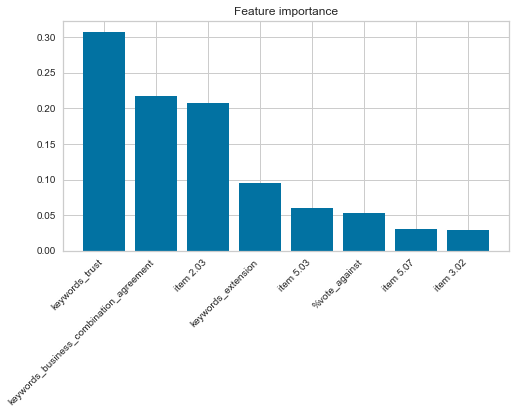

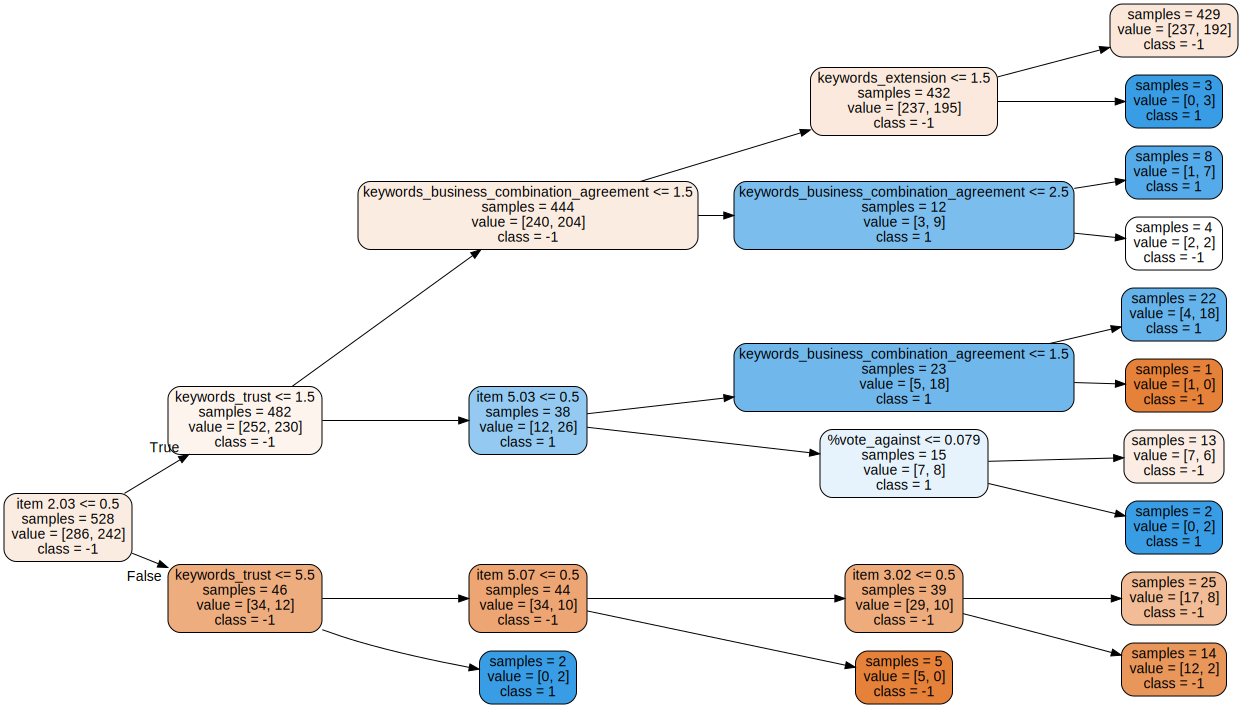

In [345]:
print('Decision Tree\n')

# CV
model_dt = DecisionTreeClassifier()
max_depth = list(range(1, 5))
# min_samples_split = [.001, .01, .05, .1]
# min_samples_leaf = [.001, .01, .05, .1]
param_grid = dict(max_depth=max_depth) #, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
kfold = TimeSeriesSplit(n_splits=5) # in each split test indices must be higher than before
grid_search = GridSearchCV(model_dt, param_grid, scoring='f1', cv=kfold, verbose=0, n_jobs=5)
grid_result = grid_search.fit(X_train, y_train)
print('Best 5-fold CV (TimeSeriesSplit) score: %f using %s' %
      (grid_result.best_score_, grid_result.best_params_), '\n')
reg_path = pd.DataFrame({'score': grid_result.cv_results_['mean_test_score'], 'max_depth': max_depth})
reg_path.plot(x='max_depth')
plt.title('CV path')
plt.xlabel('max_depth')
plt.show()

# model
model_dt = DecisionTreeClassifier(max_depth=grid_result.best_params_['max_depth'])
#                                   min_samples_split=grid_result.best_params_['min_samples_split'],
#                                   min_samples_leaf=grid_result.best_params_['min_samples_leaf'])
model_dt.fit(X_train, y_train)
binary_classification_report(model_dt, X_train, X_test, y_train, y_test)

# tree diagram
tree_data = export_graphviz(model_dt, out_file=None, feature_names=X.columns, class_names=['-1','1'],
                            filled=True, rounded=True, rotate=True, impurity=False)
graph = graphviz.Source(tree_data)
graph

Random Forest

Best 5-fold CV (TimeSeriesSplit) score: 0.446304 using {'max_depth': 1, 'max_features': 0.01, 'min_samples_leaf': 0.01, 'n_estimators': 1} 

############
Training set
############
% predicted positive labels: 0.0
% actual positive labels: 0.46
confusion matrix:
 [[286   0]
 [242   0]]
              precision    recall  f1-score   support

           0       0.54      1.00      0.70       286
           1       0.00      0.00      0.00       242

    accuracy                           0.54       528
   macro avg       0.27      0.50      0.35       528
weighted avg       0.29      0.54      0.38       528



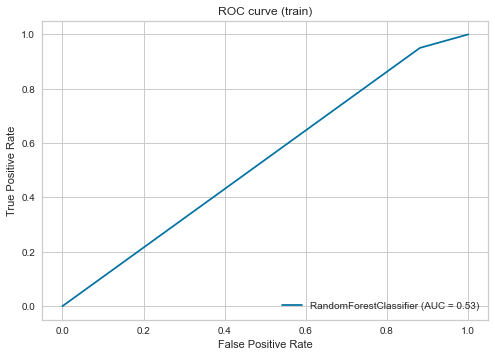

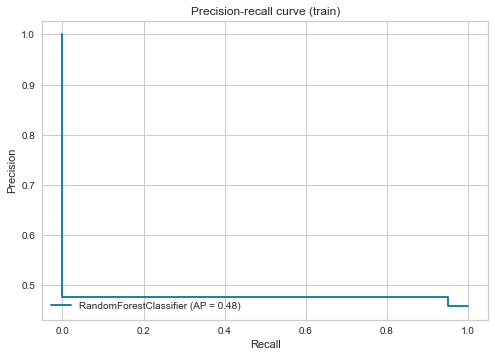

#########
Test set
#########
% predicted positive labels: 0.0
% actual positive labels: 0.47
confusion matrix:
 [[70  0]
 [63  0]]
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        70
           1       0.00      0.00      0.00        63

    accuracy                           0.53       133
   macro avg       0.26      0.50      0.34       133
weighted avg       0.28      0.53      0.36       133



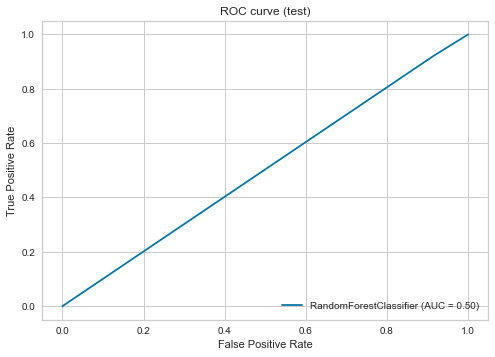

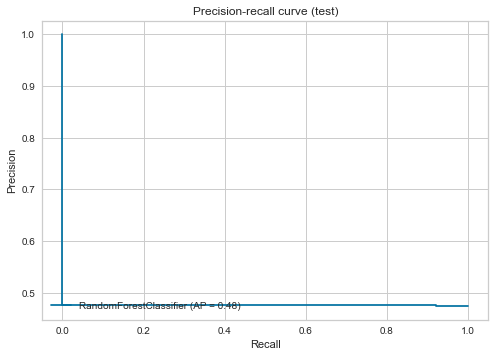

#########
All data
#########
% predicted positive labels: 0.0
% actual positive labels: 0.46
confusion matrix:
 [[356   0]
 [305   0]]
              precision    recall  f1-score   support

           0       0.54      1.00      0.70       356
           1       0.00      0.00      0.00       305

    accuracy                           0.54       661
   macro avg       0.27      0.50      0.35       661
weighted avg       0.29      0.54      0.38       661



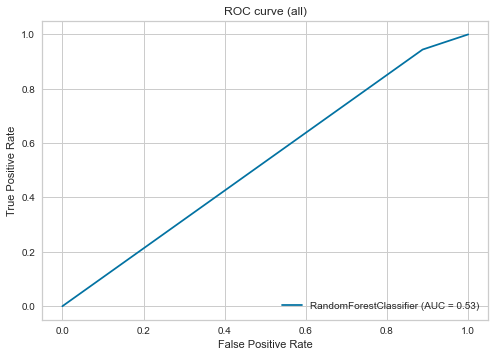

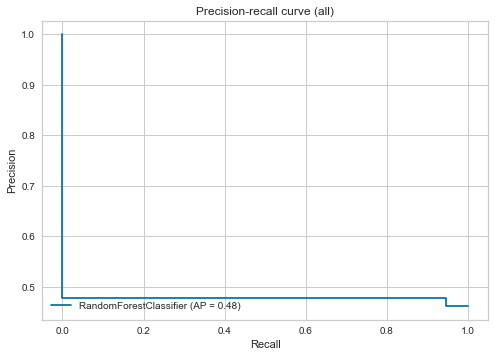

count nonzero features: 1


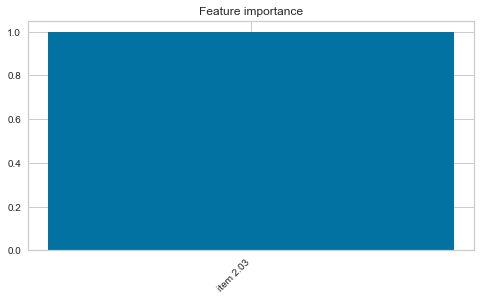

In [346]:
print('Random Forest\n')

# CV
model_rf = RandomForestClassifier()
n_estimators = list(range(1, 5))
max_depth = list(range(1, 5))
min_samples_leaf = [.01, .05, .1, .2]
max_features = [.01, .05, .1]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth,
                  min_samples_leaf=min_samples_leaf, max_features=max_features)
kfold = TimeSeriesSplit(n_splits=5) # in each split test indices must be higher than before
grid_search = GridSearchCV(model_rf, param_grid, scoring='f1', cv=kfold, verbose=0, n_jobs=5)
grid_result = grid_search.fit(X_train, y_train)
print('Best 5-fold CV (TimeSeriesSplit) score: %f using %s' %
      (grid_result.best_score_, grid_result.best_params_), '\n')

# model
model_rf = RandomForestClassifier(n_estimators=grid_result.best_params_['n_estimators'],
                                  max_depth=grid_result.best_params_['max_depth'],
                                  min_samples_leaf=grid_result.best_params_['min_samples_leaf'],
                                  max_features=grid_result.best_params_['max_features'])
model_rf.fit(X_train, y_train)
binary_classification_report(model_rf, X_train, X_test, y_train, y_test)

SVM

Best 5-fold CV (TimeSeriesSplit) score: 0.400808 using {'C': 10} 



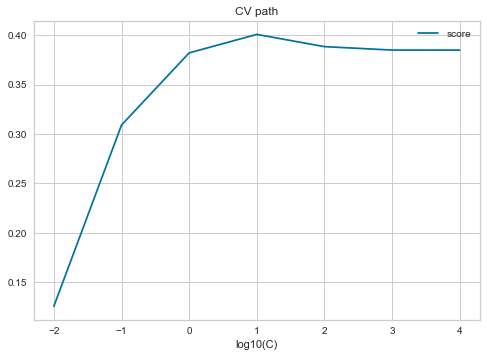

############
Training set
############
% predicted positive labels: 0.17
% actual positive labels: 0.46
confusion matrix:
 [[257  29]
 [180  62]]
              precision    recall  f1-score   support

           0       0.59      0.90      0.71       286
           1       0.68      0.26      0.37       242

    accuracy                           0.60       528
   macro avg       0.63      0.58      0.54       528
weighted avg       0.63      0.60      0.56       528



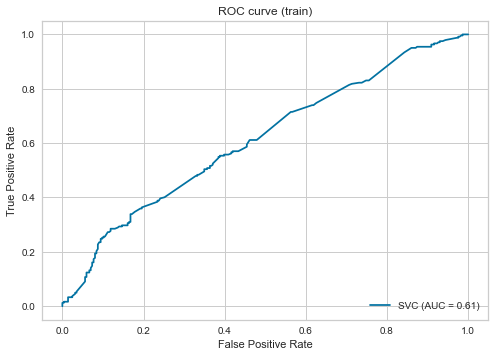

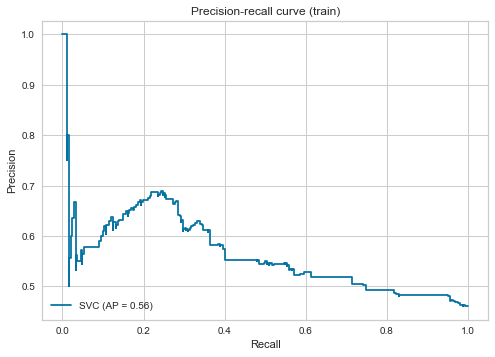

#########
Test set
#########
% predicted positive labels: 0.23
% actual positive labels: 0.47
confusion matrix:
 [[53 17]
 [50 13]]
              precision    recall  f1-score   support

           0       0.51      0.76      0.61        70
           1       0.43      0.21      0.28        63

    accuracy                           0.50       133
   macro avg       0.47      0.48      0.45       133
weighted avg       0.48      0.50      0.45       133



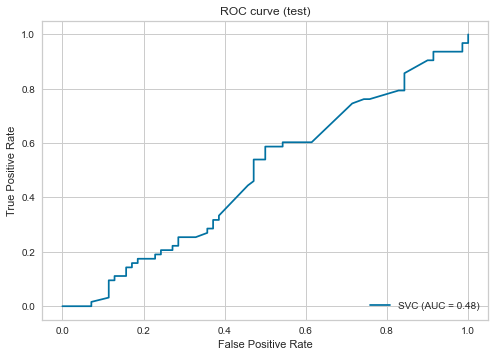

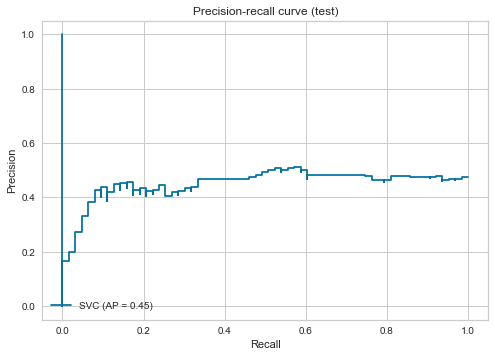

#########
All data
#########
% predicted positive labels: 0.18
% actual positive labels: 0.46
confusion matrix:
 [[310  46]
 [230  75]]
              precision    recall  f1-score   support

           0       0.57      0.87      0.69       356
           1       0.62      0.25      0.35       305

    accuracy                           0.58       661
   macro avg       0.60      0.56      0.52       661
weighted avg       0.60      0.58      0.54       661



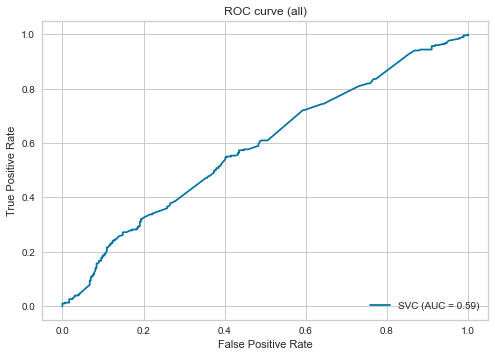

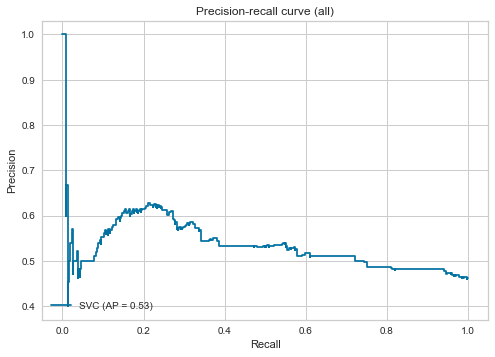

In [347]:
print('SVM\n')

kernel_type = 'linear' # linear, rbf, poly

# CV
model_svm = SVC(kernel=kernel_type)
C = [.01, .1, 1, 10, 100, 1000, 10000]
# C = [.6, .7, .8, .9, 1, 1.1, 1.2]
param_grid = dict(C=C)
kfold = TimeSeriesSplit(n_splits=5) # in each split test indices must be higher than before
grid_search = GridSearchCV(model_svm, param_grid, scoring='f1', cv=kfold, verbose=0, n_jobs=5)
grid_result = grid_search.fit(X_train, y_train)
print('Best 5-fold CV (TimeSeriesSplit) score: %f using %s' %
      (grid_result.best_score_, grid_result.best_params_), '\n')
reg_path = pd.DataFrame({'score': grid_result.cv_results_['mean_test_score'], 'C': C})
reg_path['C'] = np.log10(reg_path['C'])
reg_path.plot(x='C')
plt.title('CV path')
plt.xlabel('log10(C)')
plt.show()

# model
model_svm = SVC(kernel=kernel_type, C=grid_result.best_params_['C'])
model_svm.fit(X_train, y_train)
binary_classification_report(model_svm, X_train, X_test, y_train, y_test, feature_importance=False)

#### 3-Class Classification

In [92]:
def get_multi_labels(x):
    if x < first_label_threshold:
        return -1
    elif x > second_label_threshold:
        return 1
    else:
        return 0
    
def plot_roc_multi(model_multi, X_input, y_input):
    y_binarized = preprocessing.label_binarize(y_input, classes=[-1, 0, 1])
    n_classes = y_binarized.shape[1]
    fpr = dict()
    tpr = dict()
    from itertools import cycle
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_binarized[:, i], model_multi.predict_proba(X_input)[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    colors = cycle(['blue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=1,
                 label='ROC curve of class {0} (AUC = {1:0.2f})'
                 ''.format(i-1, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    
def multi_classification_eval_metrics(y_actual, y_pred):
    print('% predicted (actual) -1 labels: {} ({})'.format(np.round(sum(y_pred==-1)/len(y_pred), 2),
                                                           np.round(sum(y_actual==-1)/len(y_actual), 2)))
    print('% predicted (actual) 0 labels: {} ({})'.format(np.round(sum(y_pred==0)/len(y_pred), 2),
                                                          np.round(sum(y_actual==0)/len(y_actual), 2)))
    print('% predicted (actual) 1 labels: {} ({})'.format(np.round(sum(y_pred==1)/len(y_pred), 2),
                                                          np.round(sum(y_actual==1)/len(y_actual), 2)))
    cm = confusion_matrix(y_actual, y_pred)
    print('confusion matrix:\n', cm)
    print(classification_report(y_actual, y_pred, target_names=['-1','0','1']))
    
def multi_classification_report(model_multi, X_train, X_test, y_train, y_test, feature_importance=True):
    print('############\nTraining set\n############')
    y_pred_train = model_multi.predict(X_train)
    multi_classification_eval_metrics(y_train, y_pred_train)
    plot_roc_multi(model_multi, X_train, y_train)

    print('#########\nTest set\n#########')
    y_pred = model_multi.predict(X_test)
    multi_classification_eval_metrics(y_test, y_pred)
    plot_roc_multi(model_multi, X_test, y_test)

    # feature importance
    if feature_importance:
        try:
            coefs = model_multi.coef_[0]
        except:
            coefs = model_multi.feature_importances_
        indices = np.argsort(np.abs(coefs))[::-1]
        print('count nonzero features:', len(X.columns[coefs!=0]))
        top_n_features = 20 #len(X.columns[coefs!=0])
        plt.bar(range(top_n_features), coefs[indices[:top_n_features]], align='center')
        plt.xticks(range(top_n_features), X.columns[indices[:top_n_features]], rotation=45, ha='right')
        plt.subplots_adjust(bottom=0.3)
        plt.title('Feature importance')
        plt.show()

In [93]:
# inputs
first_label_threshold = -0.05 #-0.17
second_label_threshold = 0.05 #0.38
min_word_freq = 0
n_lsa = None

# prep data
X = df_returns_warrants.drop([y_variable,'symbol','date','text'], axis=1)
print('count features:', len(X.columns))
X = X[X.columns[X.sum() >= min_word_freq].tolist()] # min word frequency
print('count features > min_word_freq:', len(X.columns))
if n_lsa is not None:
    X = apply_lsa_dim_reduction(X, n_lsa) # lsa dimension reduction
y = df_returns_warrants[y_variable].map(get_multi_labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
print('training dim:', X_train.shape)
print('testing dim:', X_test.shape, '\n')
print('count -1:', np.sum(y==-1))
print('count 0:', np.sum(y==0))
print('count 1:', np.sum(y==1), '\n')

count features: 38
count features > min_word_freq: 27
training dim: (535, 27)
testing dim: (134, 27) 

count -1: 221
count 0: 215
count 1: 233 



Logistic Regression

Best 5-fold CV (TimeSeriesSplit) score: 0.362891 using {'C': 50}


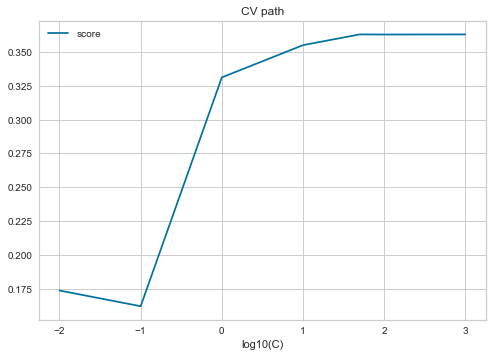

############
Training set
############
% predicted (actual) -1 labels: 0.26 (0.32)
% predicted (actual) 0 labels: 0.33 (0.33)
% predicted (actual) 1 labels: 0.41 (0.35)
confusion matrix:
 [[66 43 64]
 [35 84 56]
 [38 52 97]]
              precision    recall  f1-score   support

          -1       0.47      0.38      0.42       173
           0       0.47      0.48      0.47       175
           1       0.45      0.52      0.48       187

    accuracy                           0.46       535
   macro avg       0.46      0.46      0.46       535
weighted avg       0.46      0.46      0.46       535



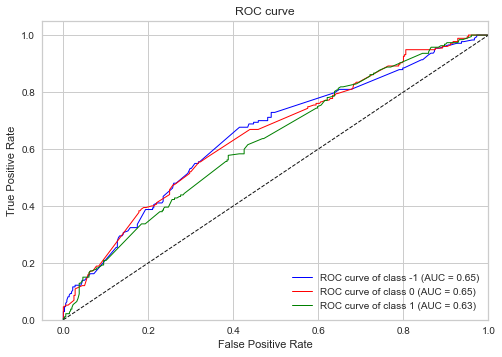

#########
Test set
#########
% predicted (actual) -1 labels: 0.31 (0.36)
% predicted (actual) 0 labels: 0.35 (0.3)
% predicted (actual) 1 labels: 0.34 (0.34)
confusion matrix:
 [[16 17 15]
 [14 12 14]
 [11 18 17]]
              precision    recall  f1-score   support

          -1       0.39      0.33      0.36        48
           0       0.26      0.30      0.28        40
           1       0.37      0.37      0.37        46

    accuracy                           0.34       134
   macro avg       0.34      0.33      0.33       134
weighted avg       0.34      0.34      0.34       134



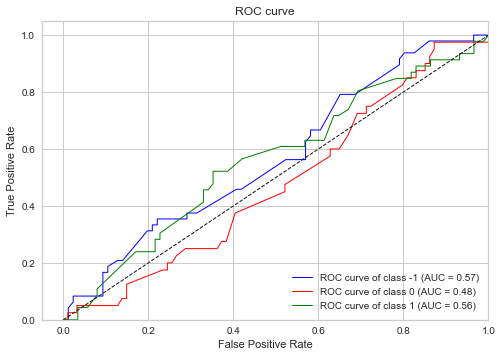

count nonzero features: 26


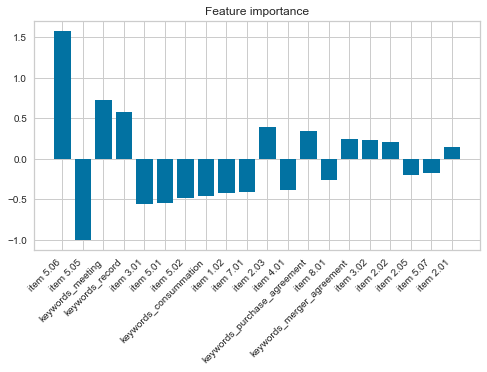

In [94]:
print('Logistic Regression\n')

# CV
model_lr_multi = LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial')
C = [.01, .1, 1, 10, 50, 100, 1000]
param_grid = dict(C=C)
kfold = TimeSeriesSplit(n_splits=5) # in each split test indices must be higher than before
grid_search = GridSearchCV(model_lr_multi, param_grid, scoring=metrics.make_scorer(metrics.f1_score, average='macro'),
                           cv=kfold, verbose=0, n_jobs=5)
grid_result = grid_search.fit(X_train, y_train)
print('Best 5-fold CV (TimeSeriesSplit) score: %f using %s' % (grid_result.best_score_, grid_result.best_params_))
reg_path = pd.DataFrame({'score': grid_result.cv_results_['mean_test_score'], 'C': C})
reg_path['C'] = np.log10(reg_path['C'])
reg_path.plot(x='C')
plt.title('CV path')
plt.xlabel('log10(C)')
plt.show()

# model
model_lr_multi = LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial',
                                    C=grid_result.best_params_['C'])
model_lr_multi.fit(X_train, y_train)
multi_classification_report(model_lr_multi, X_train, X_test, y_train, y_test)

Decision Tree

Best 5-fold CV (TimeSeriesSplit) score: 0.168610 using {'max_depth': 6} 



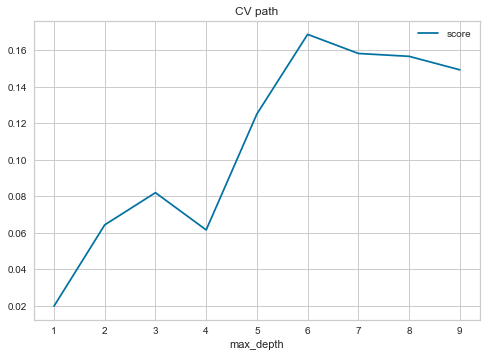

############
Training set
############
% predicted (actual) -1 labels: 0.54 (0.32)
% predicted (actual) 0 labels: 0.24 (0.33)
% predicted (actual) 1 labels: 0.21 (0.35)
confusion matrix:
 [[129  25  19]
 [ 74  69  32]
 [ 87  36  64]]
              precision    recall  f1-score   support

          -1       0.44      0.75      0.56       173
           0       0.53      0.39      0.45       175
           1       0.56      0.34      0.42       187

    accuracy                           0.49       535
   macro avg       0.51      0.49      0.48       535
weighted avg       0.51      0.49      0.48       535



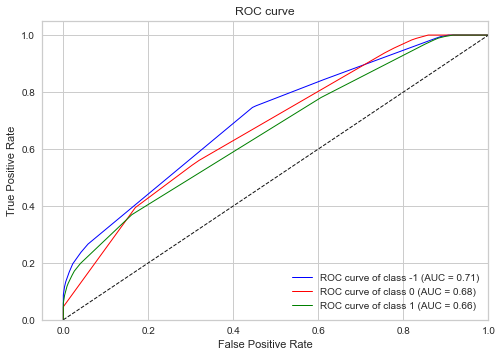

#########
Test set
#########
% predicted (actual) -1 labels: 0.56 (0.36)
% predicted (actual) 0 labels: 0.24 (0.3)
% predicted (actual) 1 labels: 0.2 (0.34)
confusion matrix:
 [[27 12  9]
 [25  8  7]
 [23 12 11]]
              precision    recall  f1-score   support

          -1       0.36      0.56      0.44        48
           0       0.25      0.20      0.22        40
           1       0.41      0.24      0.30        46

    accuracy                           0.34       134
   macro avg       0.34      0.33      0.32       134
weighted avg       0.34      0.34      0.33       134



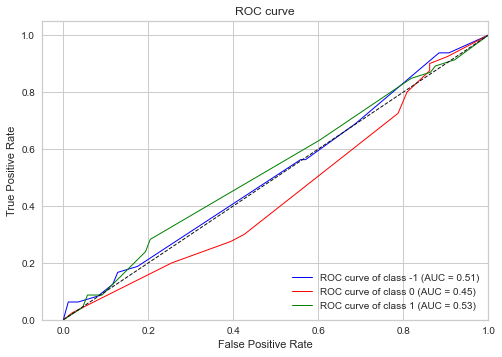

count nonzero features: 16


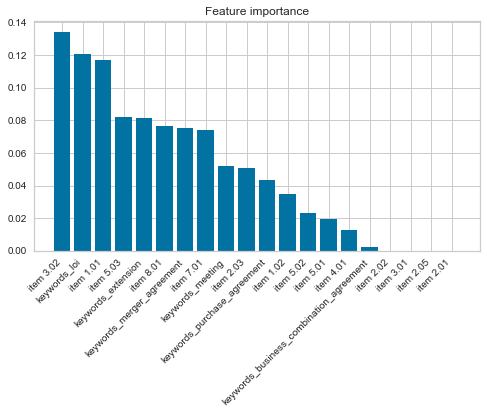

In [95]:
print('Decision Tree\n')

# CV
model_dt_multi = DecisionTreeClassifier()
max_depth = list(range(1, 10))
param_grid = dict(max_depth=max_depth)
kfold = TimeSeriesSplit(n_splits=5) # in each split test indices must be higher than before
grid_search = GridSearchCV(model_dt_multi, param_grid, scoring='f1_macro', cv=kfold, verbose=0, n_jobs=5)
y_train_binarized = preprocessing.label_binarize(y_train, classes=[-1, 0, 1])
grid_result = grid_search.fit(X_train, y_train_binarized)
print('Best 5-fold CV (TimeSeriesSplit) score: %f using %s' %
      (grid_result.best_score_, grid_result.best_params_), '\n')
reg_path = pd.DataFrame({'score': grid_result.cv_results_['mean_test_score'], 'max_depth': max_depth})
reg_path.plot(x='max_depth')
plt.title('CV path')
plt.xlabel('max_depth')
plt.show()

# model
model_dt_multi = DecisionTreeClassifier(max_depth=grid_result.best_params_['max_depth'])
model_dt_multi.fit(X_train, y_train)
multi_classification_report(model_dt_multi, X_train, X_test, y_train, y_test)

# tree diagram
# tree_data = export_graphviz(model_dt_multi, out_file=None, feature_names=X.columns, class_names=['-1','0','1'],
#                             filled=True, rounded=True, rotate=True, impurity=False)
# graph = graphviz.Source(tree_data)
# graph

Random Forest

Best 5-fold CV (TimeSeriesSplit) score: 0.176427 using {'max_depth': 4, 'max_features': 0.75, 'min_samples_leaf': 0.01, 'n_estimators': 4} 

############
Training set
############
% predicted (actual) -1 labels: 0.23 (0.32)
% predicted (actual) 0 labels: 0.25 (0.33)
% predicted (actual) 1 labels: 0.53 (0.35)
confusion matrix:
 [[ 60  28  85]
 [ 28  63  84]
 [ 34  41 112]]
              precision    recall  f1-score   support

          -1       0.49      0.35      0.41       173
           0       0.48      0.36      0.41       175
           1       0.40      0.60      0.48       187

    accuracy                           0.44       535
   macro avg       0.46      0.44      0.43       535
weighted avg       0.45      0.44      0.43       535



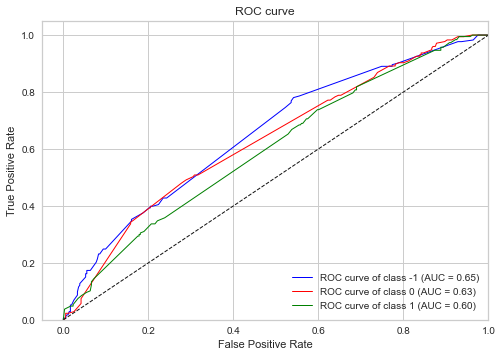

#########
Test set
#########
% predicted (actual) -1 labels: 0.27 (0.36)
% predicted (actual) 0 labels: 0.24 (0.3)
% predicted (actual) 1 labels: 0.49 (0.34)
confusion matrix:
 [[13 14 21]
 [11  8 21]
 [12 10 24]]
              precision    recall  f1-score   support

          -1       0.36      0.27      0.31        48
           0       0.25      0.20      0.22        40
           1       0.36      0.52      0.43        46

    accuracy                           0.34       134
   macro avg       0.32      0.33      0.32       134
weighted avg       0.33      0.34      0.32       134



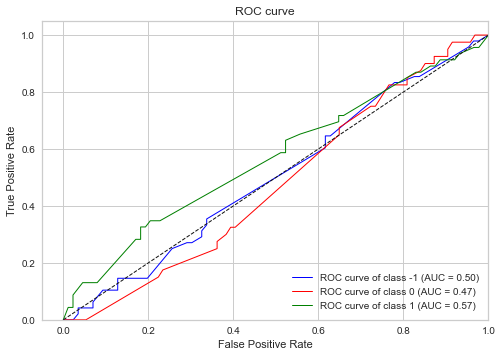

count nonzero features: 14


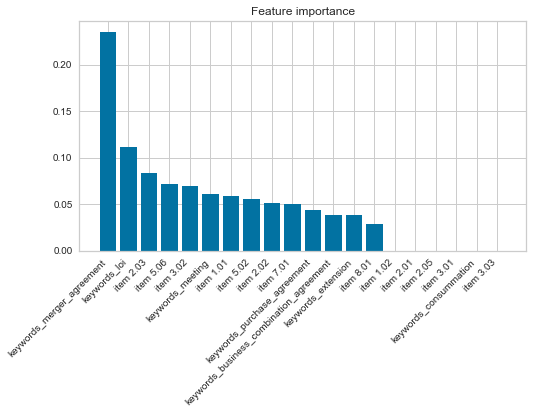

In [96]:
print('Random Forest\n')

# CV
model_rf_multi = RandomForestClassifier()
n_estimators = list(range(1, 10))
max_depth = list(range(1, 5))
min_samples_leaf = [.01, .05, .1, .2, .3]
max_features = [.05, .25, .5, .75]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth,
                  min_samples_leaf=min_samples_leaf, max_features=max_features)
kfold = TimeSeriesSplit(n_splits=5) # in each split test indices must be higher than before
grid_search = GridSearchCV(model_rf_multi, param_grid, scoring='f1_macro', cv=kfold, verbose=0, n_jobs=5)
y_train_binarized = preprocessing.label_binarize(y_train, classes=[-1, 0, 1])
grid_result = grid_search.fit(X_train, y_train_binarized)
print('Best 5-fold CV (TimeSeriesSplit) score: %f using %s' %
      (grid_result.best_score_, grid_result.best_params_), '\n')

# model
model_rf_multi = RandomForestClassifier(n_estimators=grid_result.best_params_['n_estimators'],
                                        max_depth=grid_result.best_params_['max_depth'],
                                        min_samples_leaf=grid_result.best_params_['min_samples_leaf'],
                                        max_features=grid_result.best_params_['max_features'])
model_rf_multi.fit(X_train, y_train)
multi_classification_report(model_rf_multi, X_train, X_test, y_train, y_test)

SVM

Best 5-fold CV (TimeSeriesSplit) score: 0.352769 using {'C': 10} 



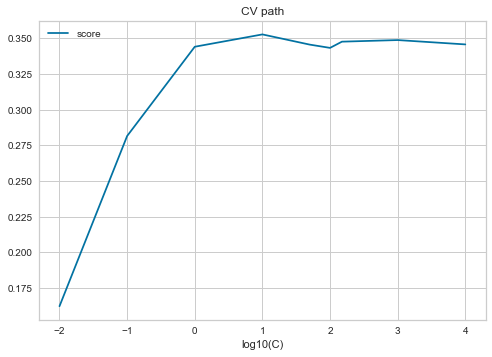

############
Training set
############
% predicted (actual) -1 labels: 0.26 (0.32)
% predicted (actual) 0 labels: 0.26 (0.33)
% predicted (actual) 1 labels: 0.48 (0.35)
confusion matrix:
 [[ 61  33  79]
 [ 37  67  71]
 [ 40  40 107]]
              precision    recall  f1-score   support

          -1       0.44      0.35      0.39       173
           0       0.48      0.38      0.43       175
           1       0.42      0.57      0.48       187

    accuracy                           0.44       535
   macro avg       0.45      0.44      0.43       535
weighted avg       0.45      0.44      0.43       535



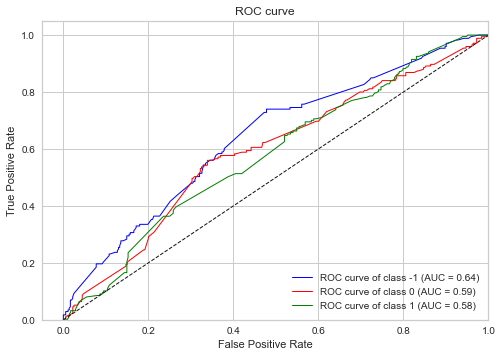

#########
Test set
#########
% predicted (actual) -1 labels: 0.31 (0.36)
% predicted (actual) 0 labels: 0.26 (0.3)
% predicted (actual) 1 labels: 0.43 (0.34)
confusion matrix:
 [[18 14 16]
 [12  8 20]
 [11 13 22]]
              precision    recall  f1-score   support

          -1       0.44      0.38      0.40        48
           0       0.23      0.20      0.21        40
           1       0.38      0.48      0.42        46

    accuracy                           0.36       134
   macro avg       0.35      0.35      0.35       134
weighted avg       0.36      0.36      0.35       134



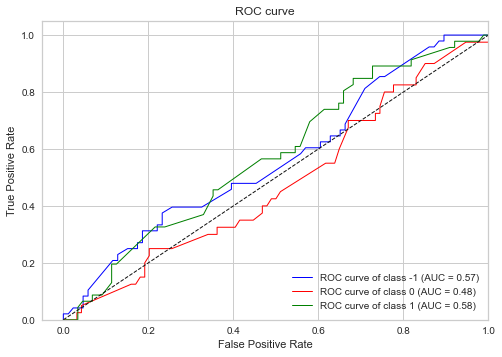

In [97]:
print('SVM\n')

kernel_type = 'linear' # linear, rbf, poly

# CV
model_svm_multi = SVC(kernel=kernel_type, probability=True)
C = [.01, .1, 1, 10, 50, 100, 150, 1000, 10000]
param_grid = dict(C=C)
kfold = TimeSeriesSplit(n_splits=5) # in each split test indices must be higher than before
grid_search = GridSearchCV(model_svm_multi, param_grid, scoring='f1_macro', cv=kfold, verbose=0, n_jobs=5)
grid_result = grid_search.fit(X_train, y_train)
print('Best 5-fold CV (TimeSeriesSplit) score: %f using %s' %
      (grid_result.best_score_, grid_result.best_params_), '\n')
reg_path = pd.DataFrame({'score': grid_result.cv_results_['mean_test_score'], 'C': C})
reg_path['C'] = np.log10(reg_path['C'])
reg_path.plot(x='C')
plt.title('CV path')
plt.xlabel('log10(C)')
plt.show()

# model
model_svm_multi = SVC(kernel=kernel_type, C=grid_result.best_params_['C'], probability=True)
model_svm_multi.fit(X_train, y_train)
multi_classification_report(model_svm_multi, X_train, X_test, y_train, y_test, feature_importance=False)